In [1]:
import os
import pandas as pd

In [2]:
def read_log_file(path, filename):
    
    """Function for reading logs with training process"""
    with open(os.path.join(path, filename), 'r') as f:
        data = f.read()
        data = data.rstrip().split('\n')
        data = list(map(lambda x: x.rstrip().split('\t'), data))[1:]
        train_RMSE = list(map(lambda x: float(x[0]), data))
        train_R2 = list(map(lambda x: float(x[2]), data))
        val_RMSE = list(map(lambda x: float(x[1]), data))
        val_R2 = list(map(lambda x: float(x[3]), data))
        return train_RMSE, train_R2, val_RMSE, val_R2

In [3]:
def plot_training_process(num_exp = '', \
                          logs_path = '../../data/raw/logs/exp_'+'', \
                          logs_filename_prefix =  ''+'_logs_metrics', \
                          logs_test_fin_file = ''+'_logs.txt', \
                          parameters_file = ''+'_parameters.json'):
    import matplotlib.pyplot as plt
    import json
    
    
    
    try:
        train_RMSE_conv, train_R2_conv, val_RMSE_conv, val_R2_conv = \
        read_log_file(logs_path, logs_filename_prefix+'_conv.txt')  
        train_RMSE_morgan, train_R2_morgan, val_RMSE_morgan, val_R2_morgan = \
        read_log_file(logs_path, logs_filename_prefix+'_morgan.txt') 
        
        with open(os.path.join(logs_path, logs_test_fin_file)) as f:
            data = f.read().rstrip().split('\n\n')[-1].split('\n')
            if len(data) == 3:
                test_R2 = float(data[-1].split(' ')[-1])
                test_RMSE = None
            elif len(data)==4:
                test_R2 = float(data[-2].split(' ')[-1])
                test_RMSE = float(data[-1].split(' ')[-1])
            elif len(data)==1:
                test_R2=None
                test_RMSE=None

        with open(os.path.join(logs_path, parameters_file)) as f:
            params = json.load(f)
            dataset_name = params['data_file']
            fp_length = params['fp_length']
    except (IOError, ValueError) as e:
        return None, None
        
    fig, ax = plt.subplots(2,2, figsize = (10,10), sharey='row', sharex='col')

    ax[0,0].plot(train_RMSE_conv, label='train')
    ax[0,0].plot(val_RMSE_conv, label = 'val')
    ax[0,0].set_ylabel('RMSE')
    ax[0,0].set_title('Neural Fingerprints')


    ax[1,0].plot(train_R2_conv, label='train')
    ax[1,0].plot(val_R2_conv, label = 'val')
    ax[1,0].set_xlabel('Iterations/10')
    ax[1,0].set_ylabel('R2')
    ax[1,0].set_ylim(-0.5,1)


    ax[0,1].plot(train_RMSE_morgan, label='train')
    ax[0,1].plot(val_RMSE_morgan, label = 'val')
    ax[0,1].set_title('Morgan Fingerprints')

    ax[1,1].plot(train_R2_morgan, label='train')
    ax[1,1].plot(val_R2_morgan, label = 'val')
    ax[1,1].set_xlabel('Iterations/10')


    for i in range(2):
        for j in range(2):
            ax[i,j].legend()

    
    title = 'Experiment ' + str(num_exp) + \
            '\n'+'Dataset: '+dataset_name + \
            '\n'+'Fingerprint length: '+str(fp_length)
    if test_R2 is not None:
        title = title + '\ntest R2 score = ' + str(round(test_R2, 2))
    if test_RMSE is not None:
        title = title + '\ntest RMSE score = ' + str(round(test_RMSE, 2))
    fig.suptitle(title)
    
    plt.show()
    
    return fig, ax

In [4]:
def summary_table(num_exp = range(4,8), logs_path = '../../data/raw/logs',logs_postfix = '_logs.txt',):
    import pandas as pd
    import os
    import json
    
    summary = []
    
    for NUM_EXP in num_exp:
        try:
            with open(os.path.join(logs_path, 'exp_'+str(NUM_EXP), str(NUM_EXP)+'_parameters.json')) as f:
                summary.append(json.load(f))
            with open(os.path.join(logs_path, 'exp_'+str(NUM_EXP), str(NUM_EXP)+logs_postfix)) as f:
                data = f.read().rstrip().split('\n\n')[-1].split('\n')
                if len(data) == 3:
                    conv_test_R2 = float(data[-1].split(' ')[-1])
                    avg_test_R2 = float(data[-2].split(' ')[-1])
                    morgan_test_R2 = float(data[-3].split(' ')[-1])
                    conv_test_RMSE = None
                elif len(data)==4:
                    conv_test_R2 = float(data[-2].split(' ')[-1])
                    avg_test_R2 = float(data[-3].split(' ')[-1])
                    morgan_test_R2 = float(data[-4].split(' ')[-1])
                    conv_test_RMSE = float(data[-1].split(' ')[-1])
                elif len(data)==1:
                    summary = summary[:-1]
                    continue
                summary[-1]['Neural Fingerprint test R2'] = conv_test_R2
                summary[-1]['Neural Fingerprint test RMSE'] = conv_test_RMSE
                summary[-1]['Average test R2'] = avg_test_R2
                summary[-1]['Morgan Fingerprint test R2'] = morgan_test_R2
            train_RMSE_conv, train_R2_conv, val_RMSE_conv, val_R2_conv = \
            read_log_file(logs_path+'/exp_'+str(NUM_EXP), str(NUM_EXP)+'_logs_metrics'+'_conv.txt')  
            train_RMSE_morgan, train_R2_morgan, val_RMSE_morgan, val_R2_morgan = \
            read_log_file(logs_path+'/exp_'+str(NUM_EXP), str(NUM_EXP)+'_logs_metrics'+'_morgan.txt') 
        except (IOError, ValueError) as e:
            summary = summary[:-1]
            continue
        summary[-1]['Neural Fingerprint train RMSE'] = train_RMSE_conv[-1]
        summary[-1]['Neural Fingerprint val RMSE'] = val_RMSE_conv[-1]
        summary[-1]['Neural Fingerprint train R2'] = train_R2_conv[-1]
        summary[-1]['Neural Fingerprint val R2'] = val_R2_conv[-1]
        
        summary[-1]['Morgan Fingerprint train RMSE'] = train_RMSE_morgan[-1]
        summary[-1]['Morgan Fingerprint val RMSE'] = val_RMSE_morgan[-1]
        summary[-1]['Morgan Fingerprint train R2'] = train_R2_morgan[-1]
        summary[-1]['Morgan Fingerprint val R2'] = val_R2_morgan[-1]
        
        summary[-1]['num_iters'] = len(train_R2_conv)*10

    return pd.DataFrame(summary)
        

# Plot training process

In [5]:
NUM_EXPs = list(map(lambda x: x.split('_')[1], os.listdir('../../data/raw/logs')))

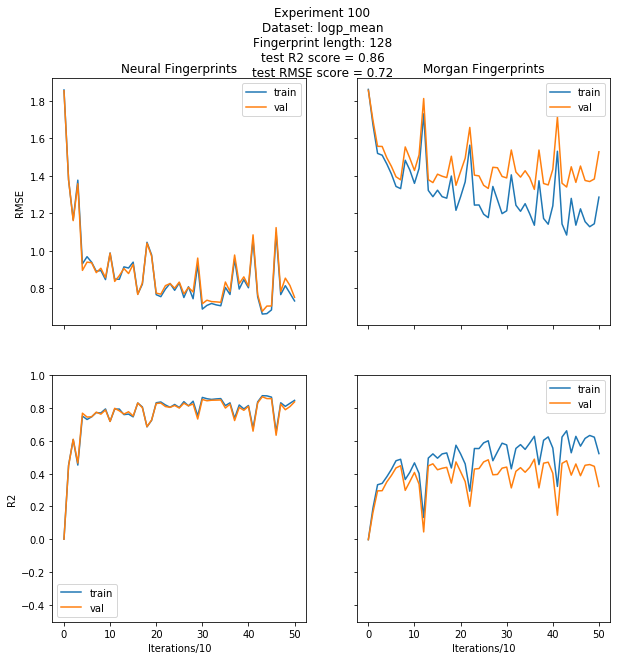

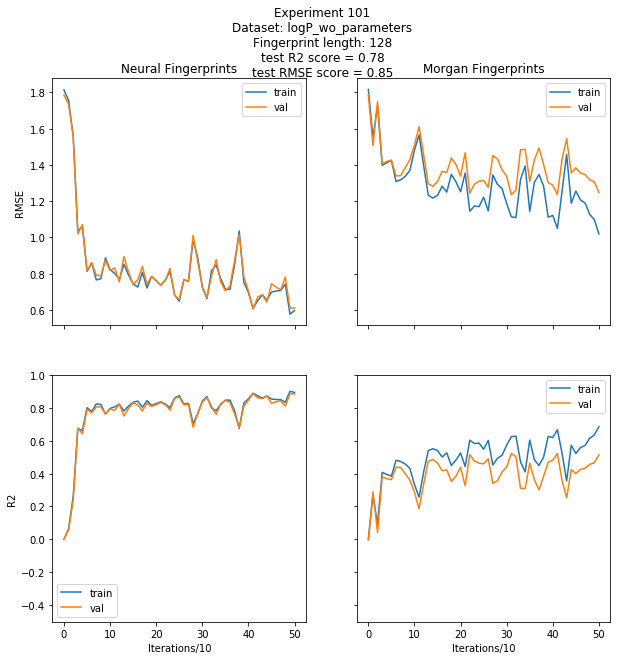

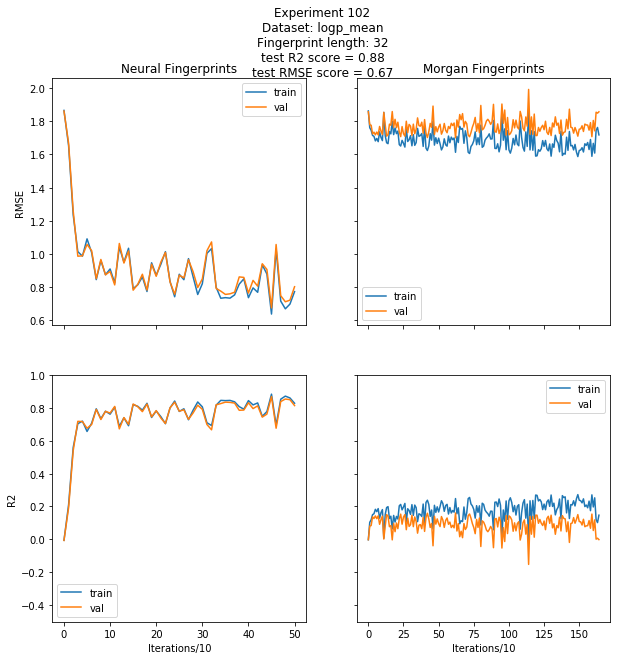

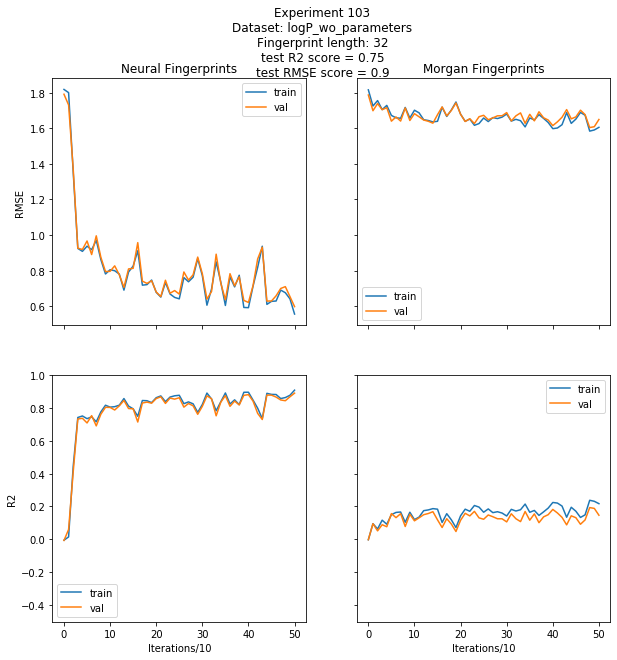

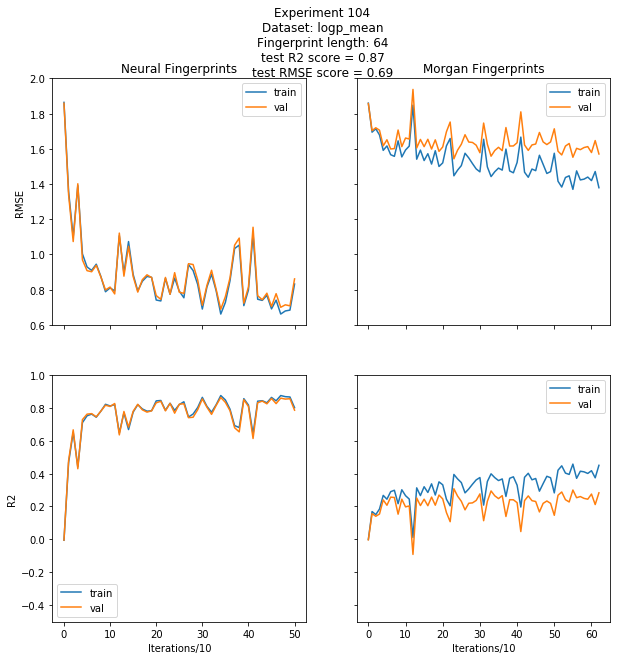

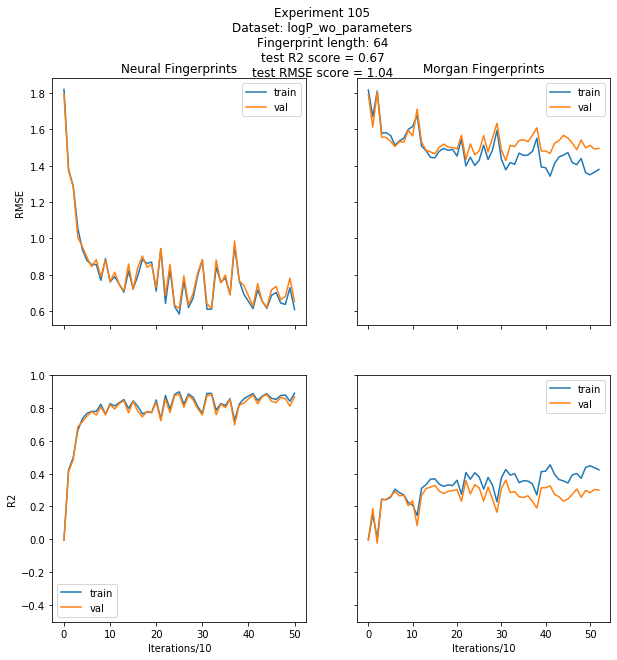

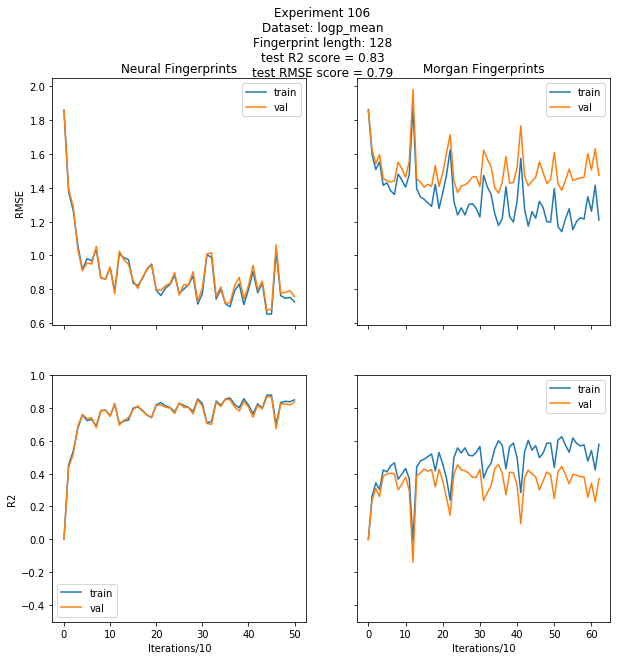

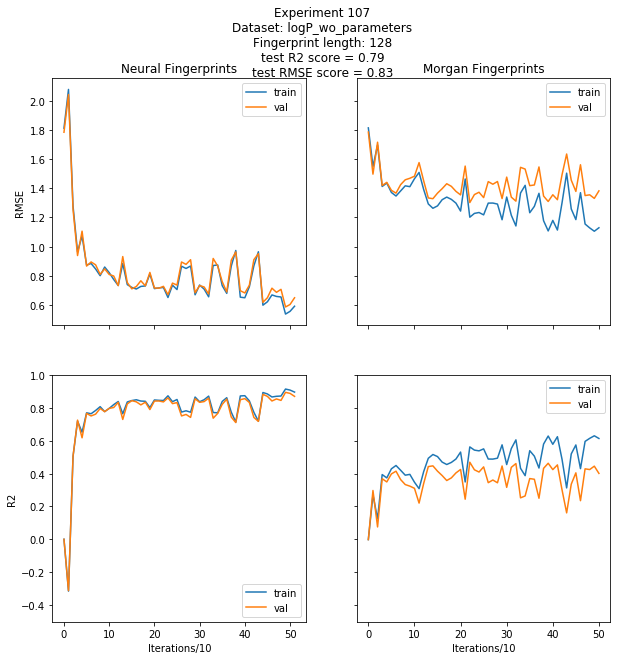

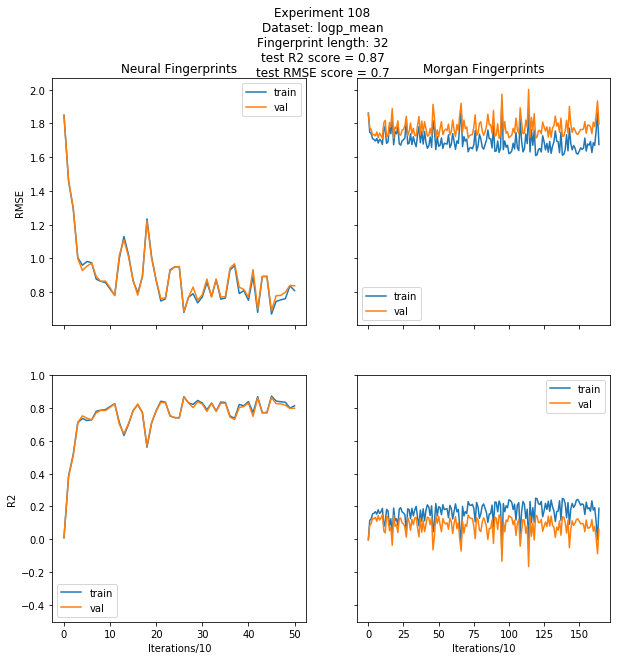

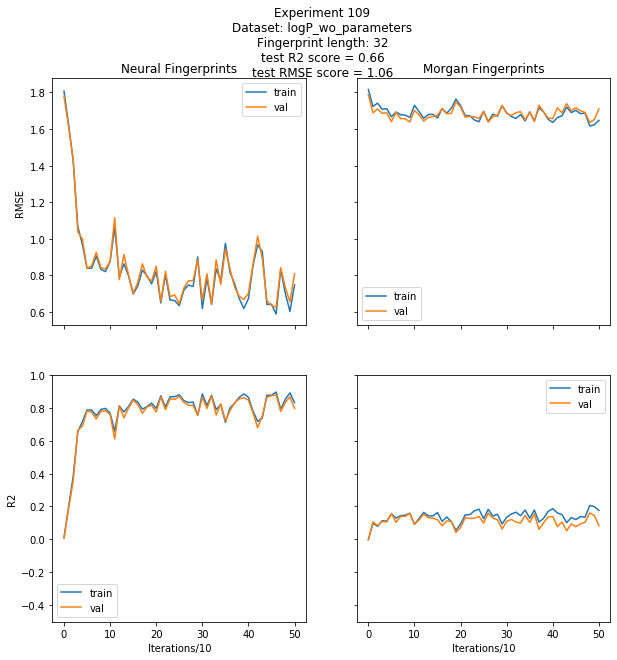

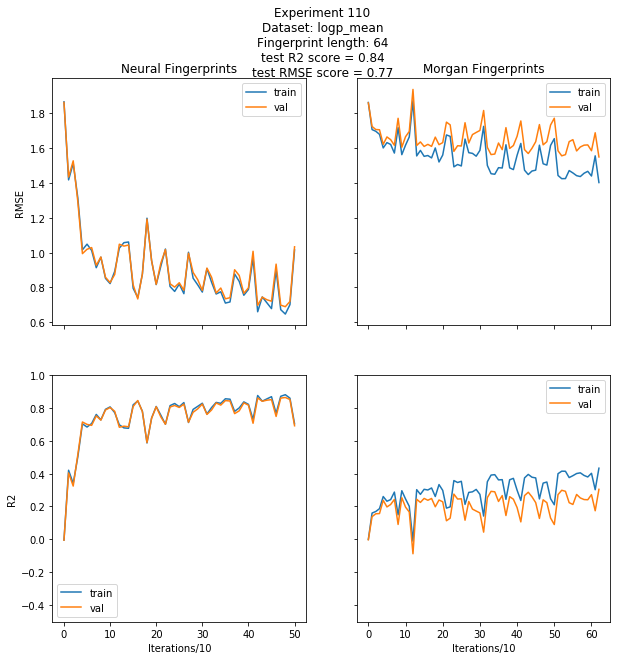

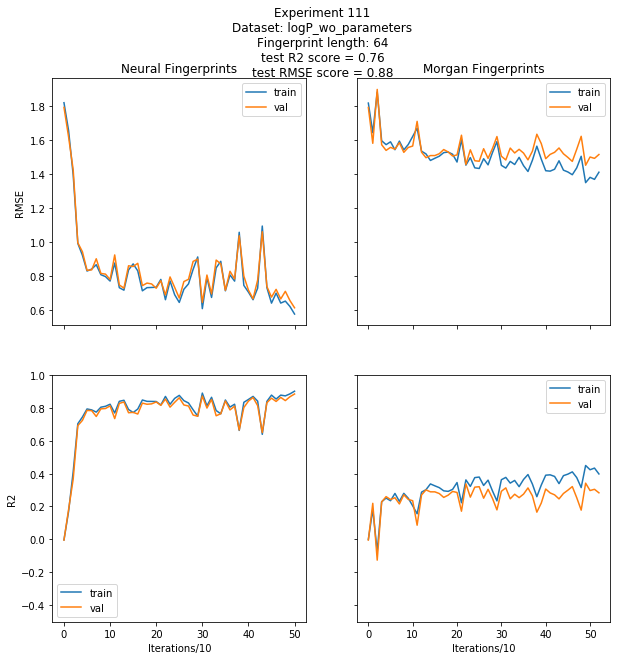

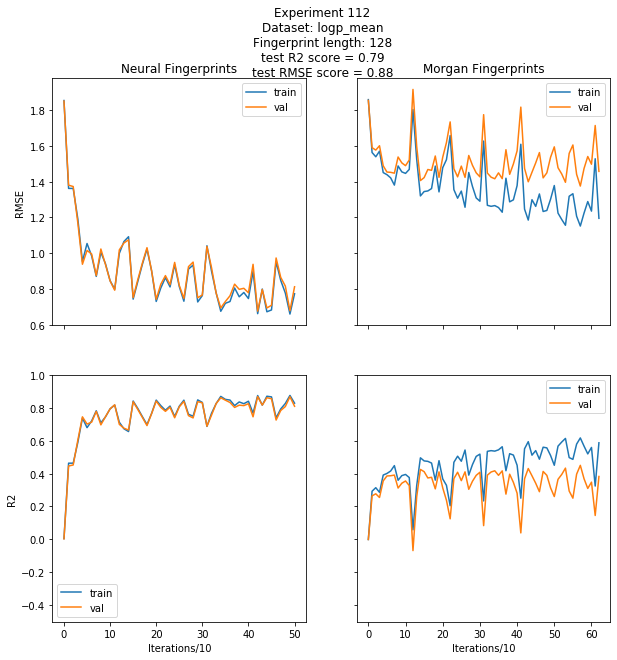

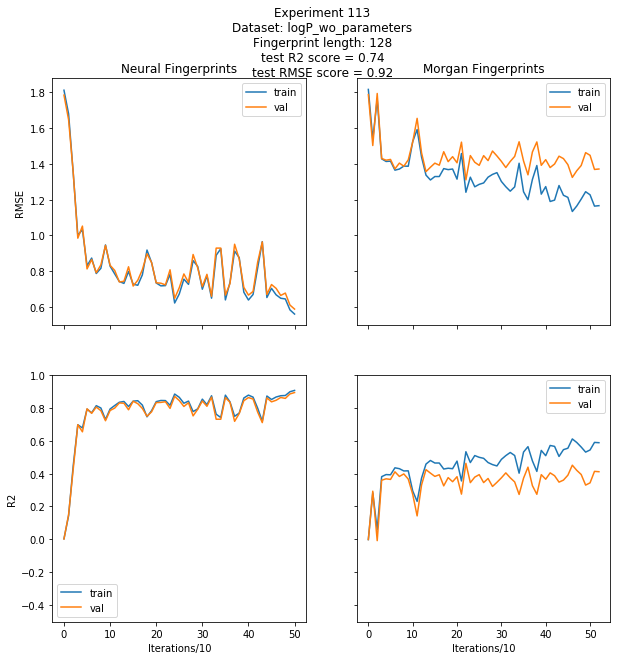

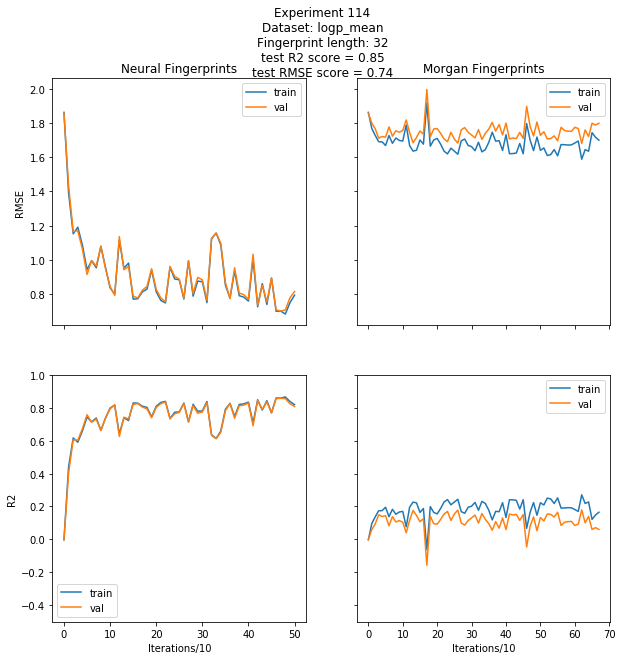

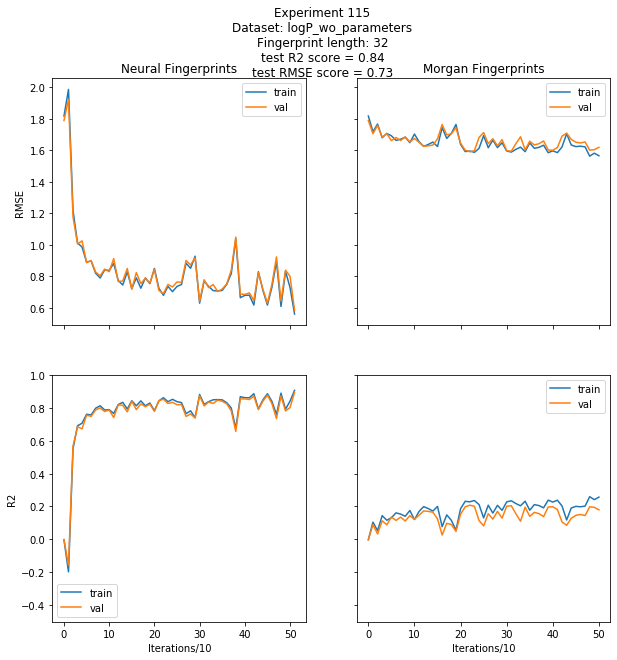

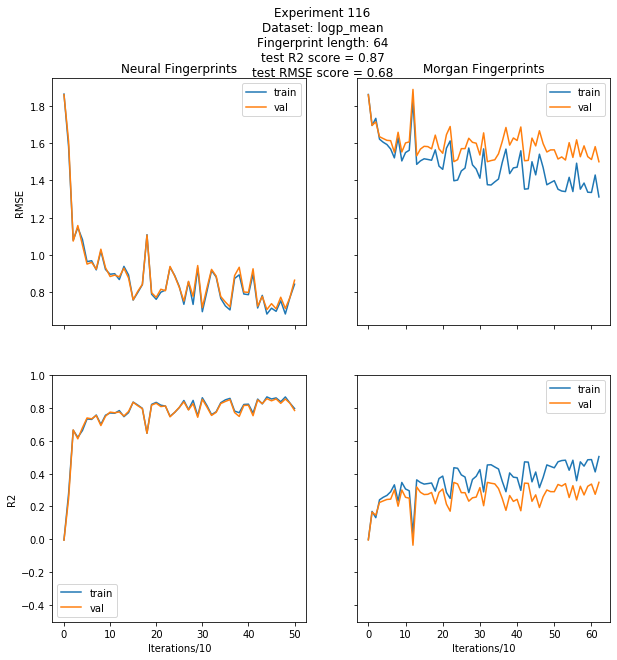

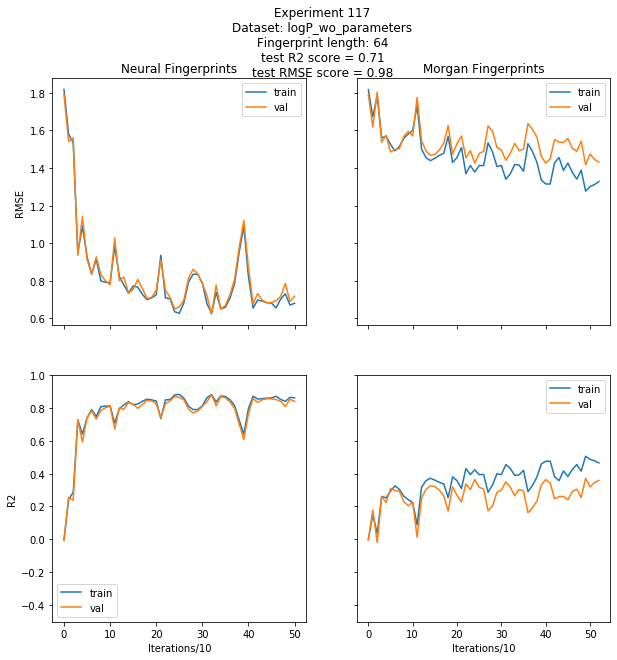

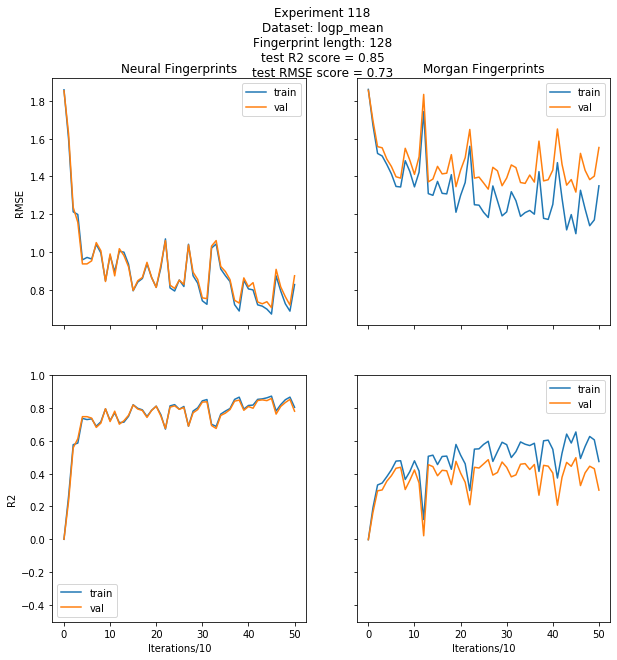

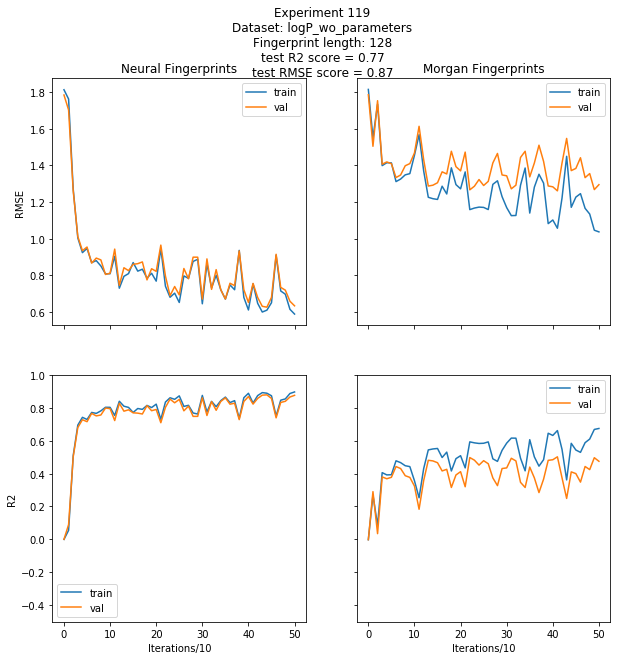

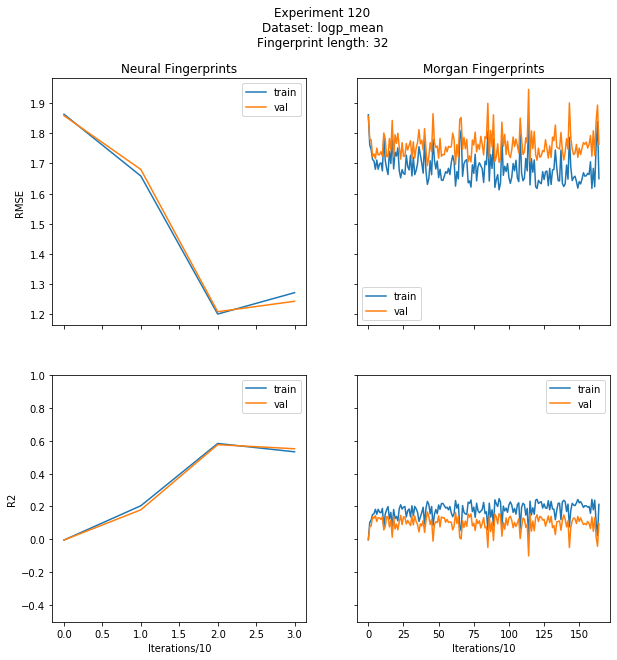

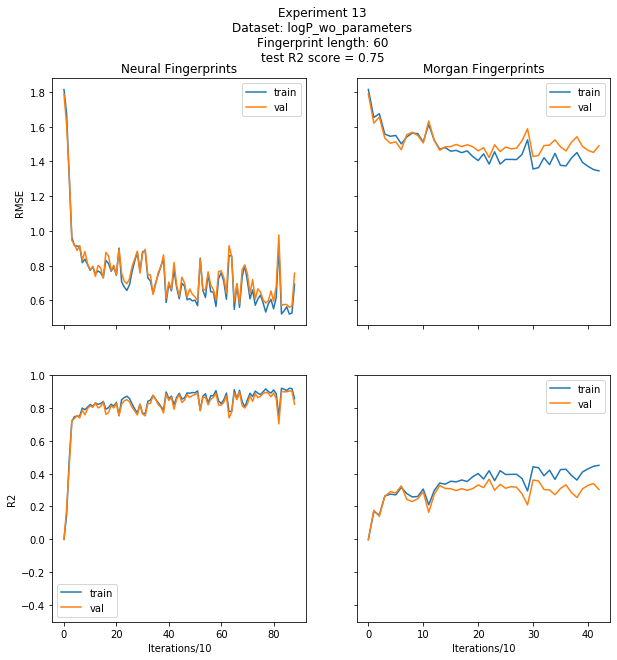

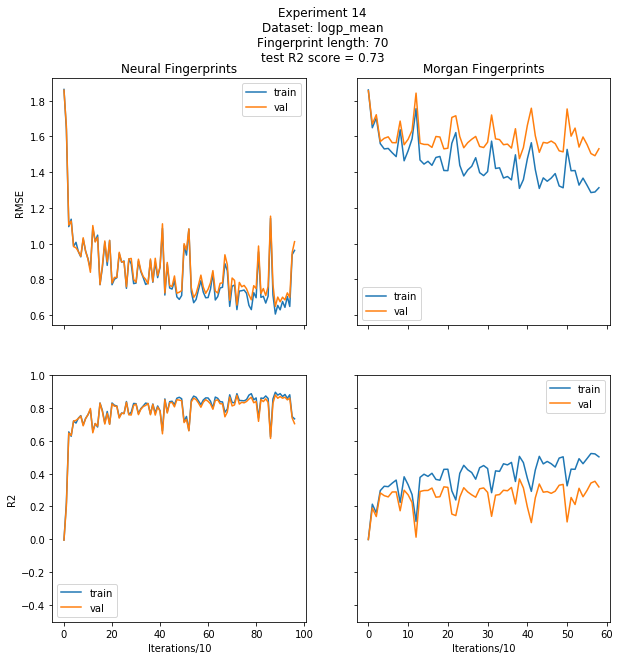

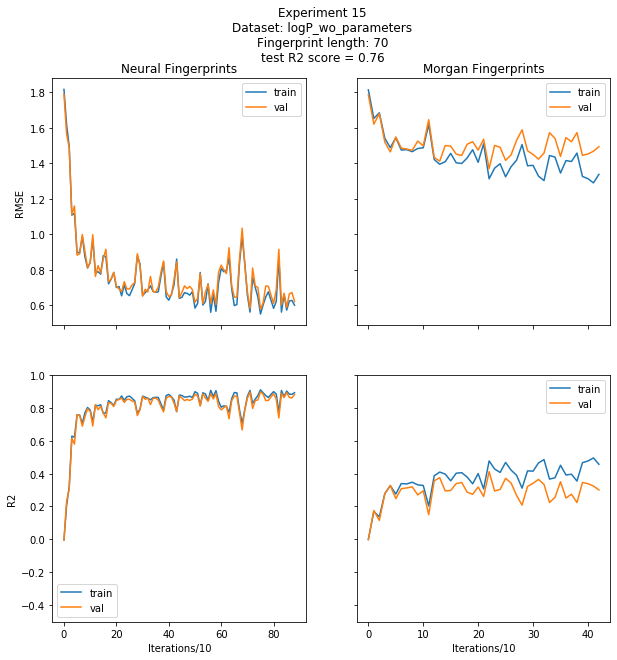

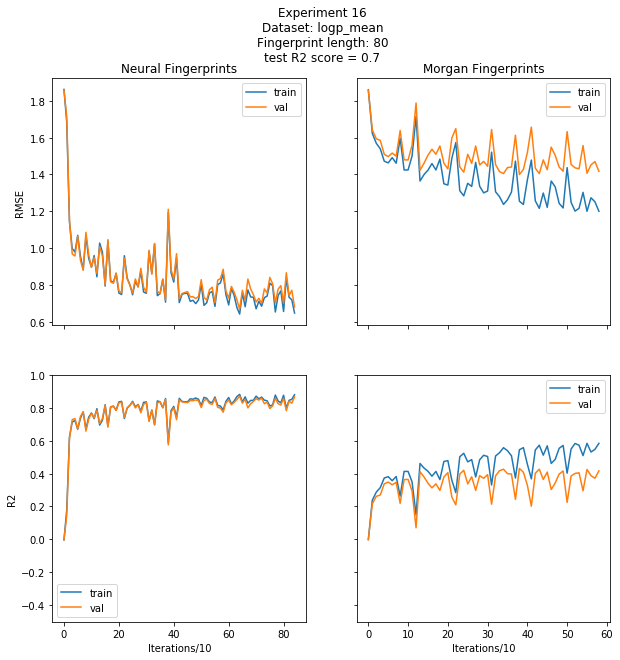

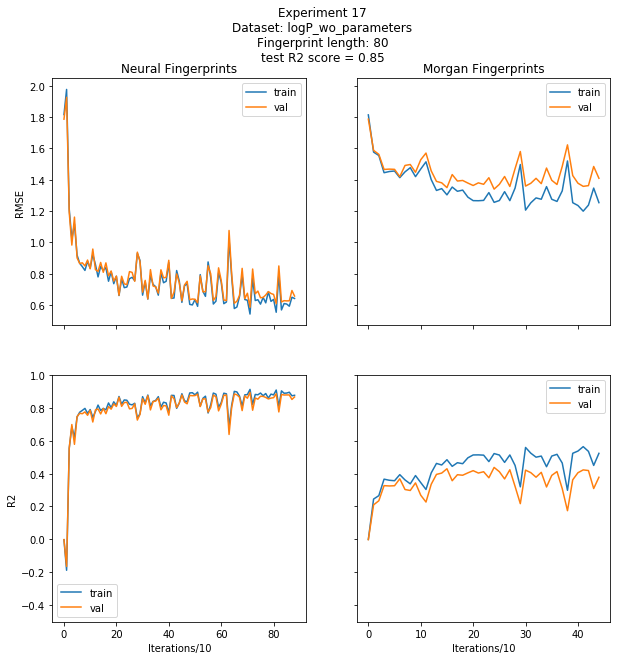

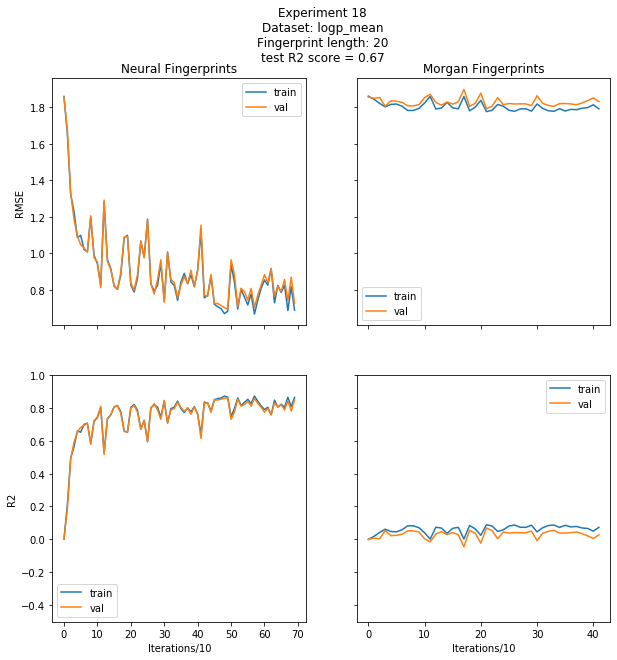

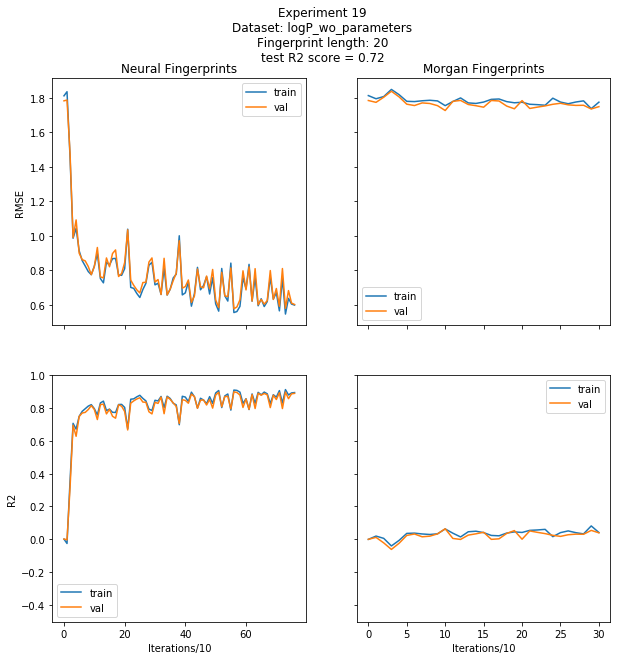

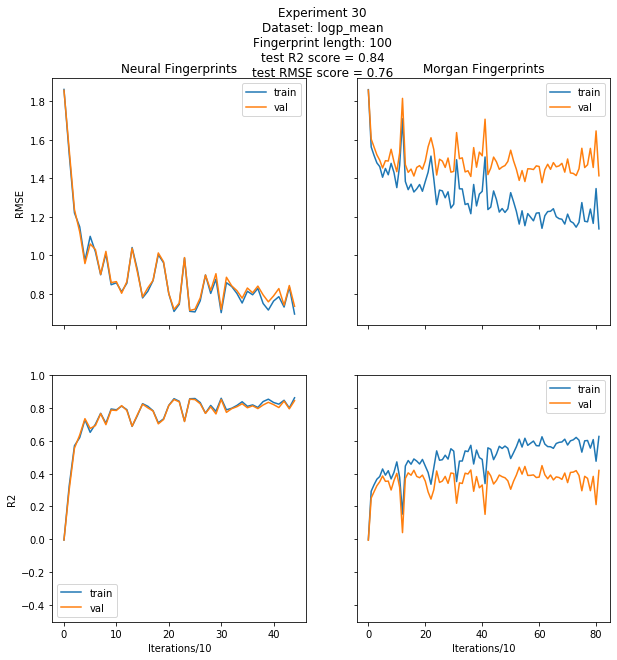

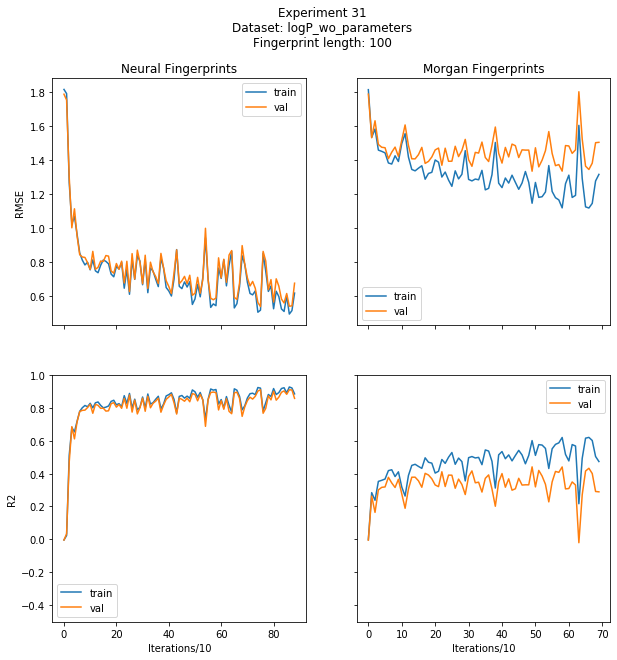

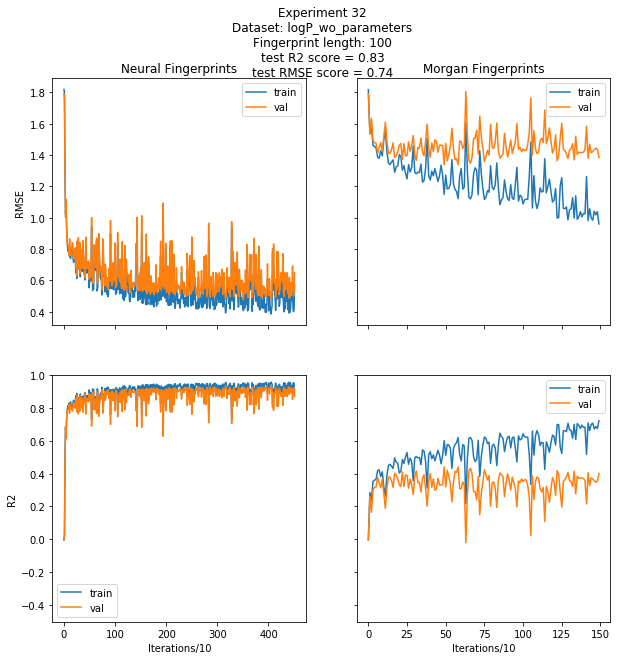

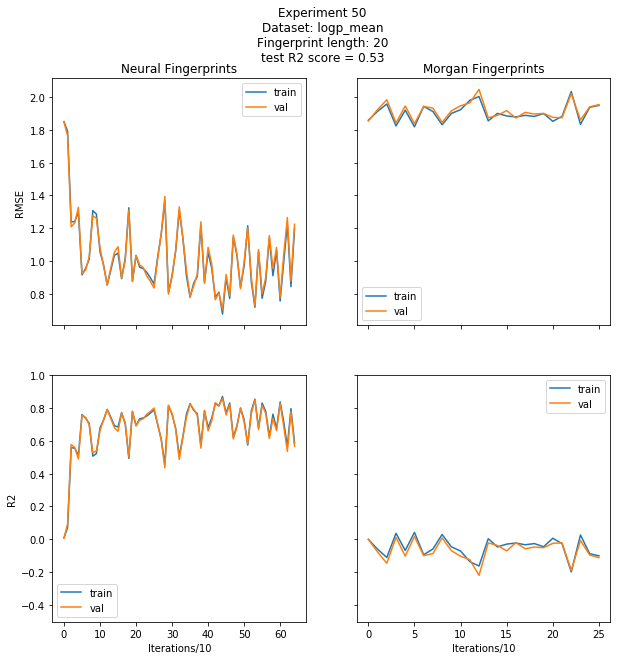

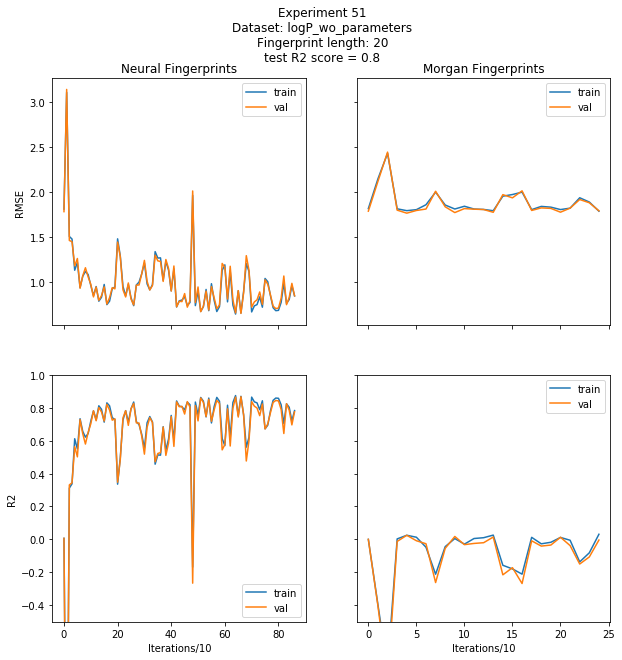

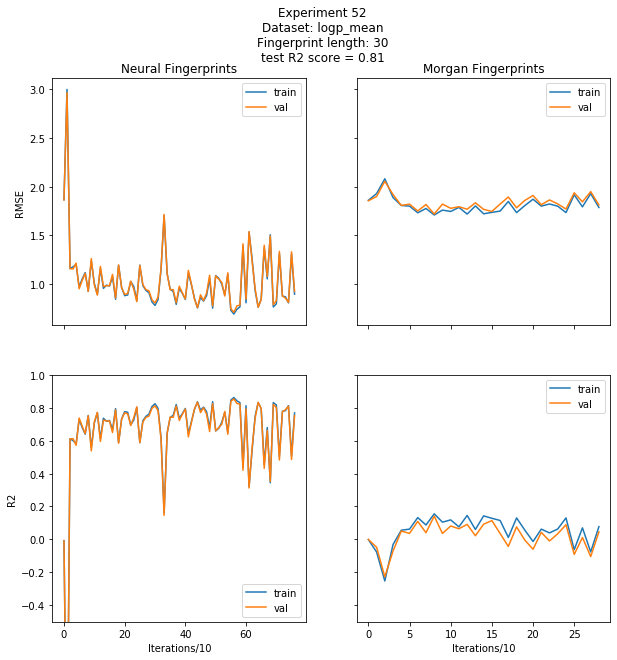

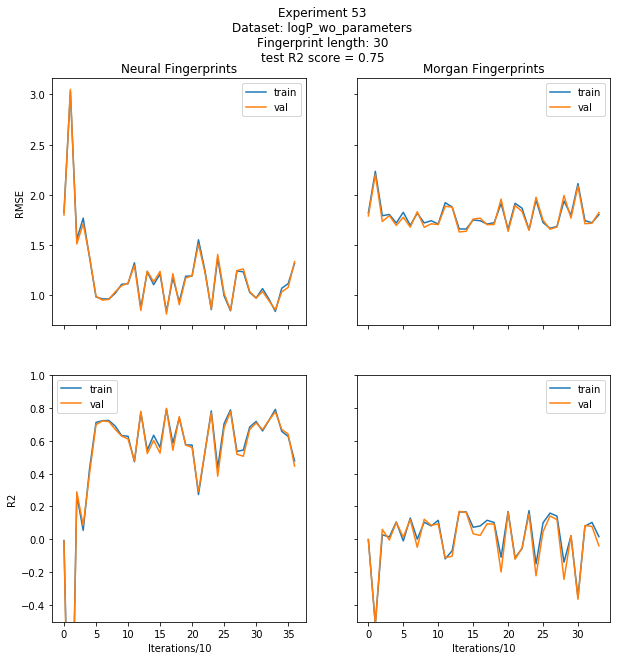

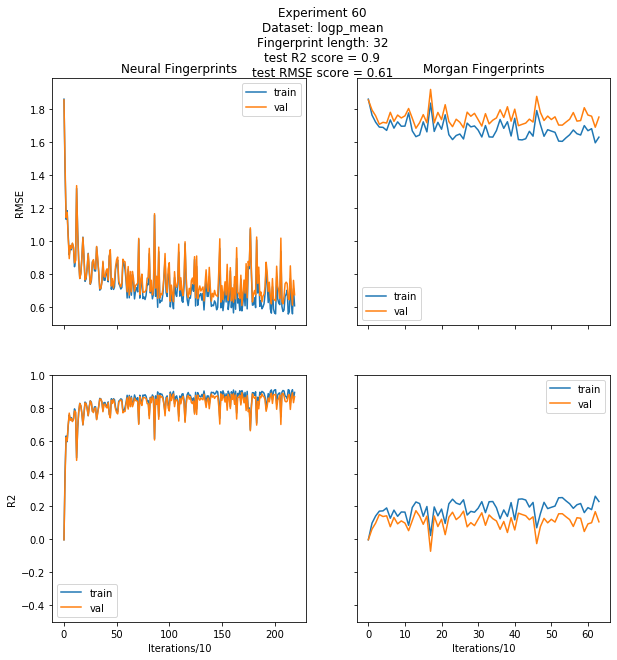

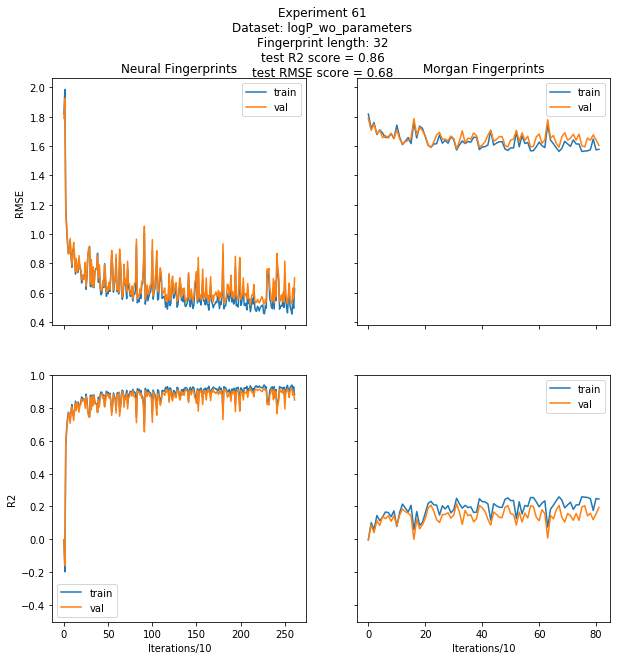

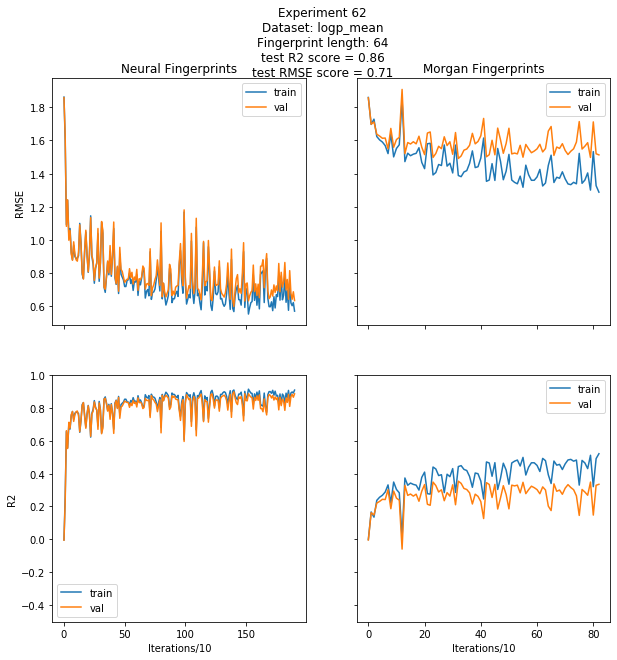

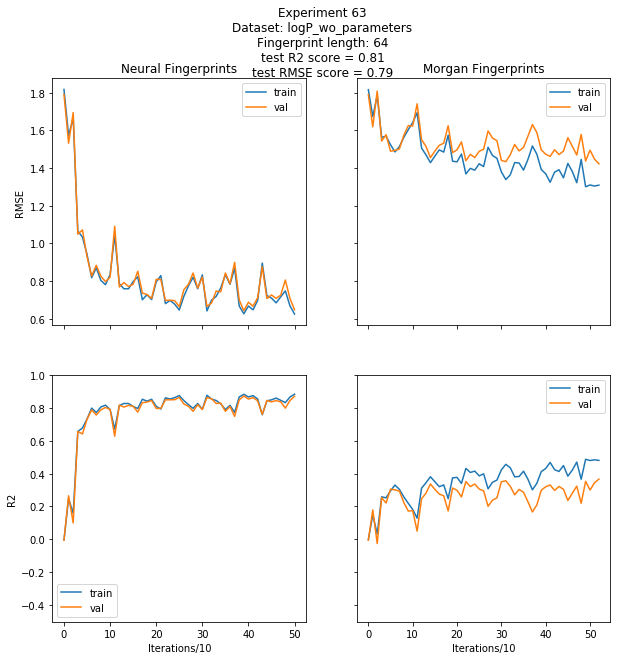

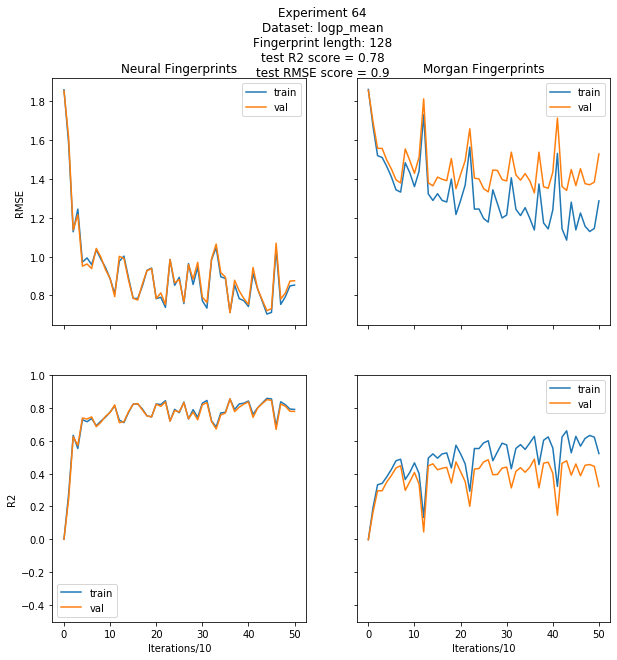

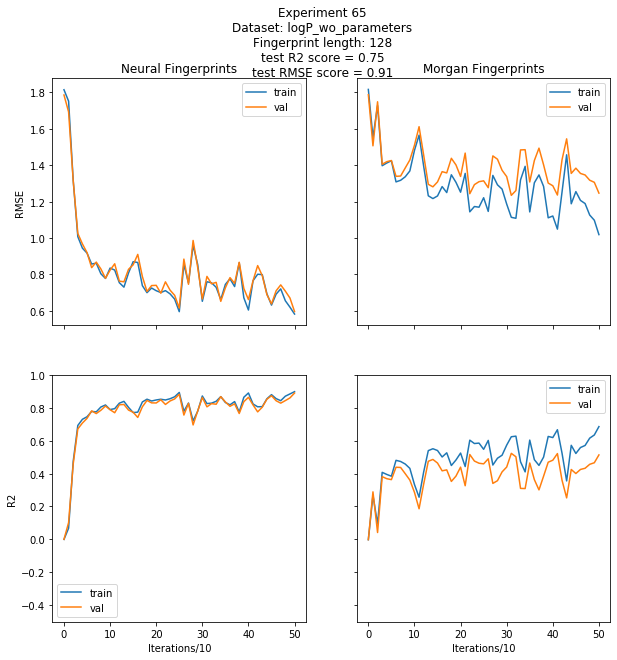

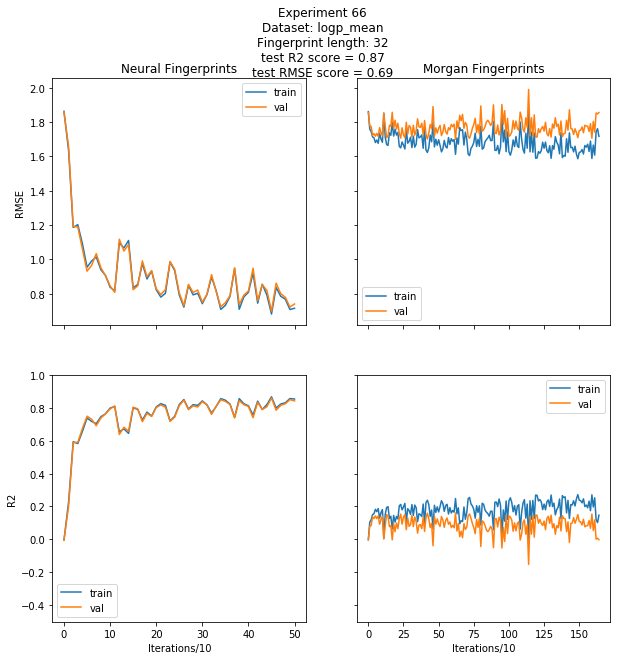

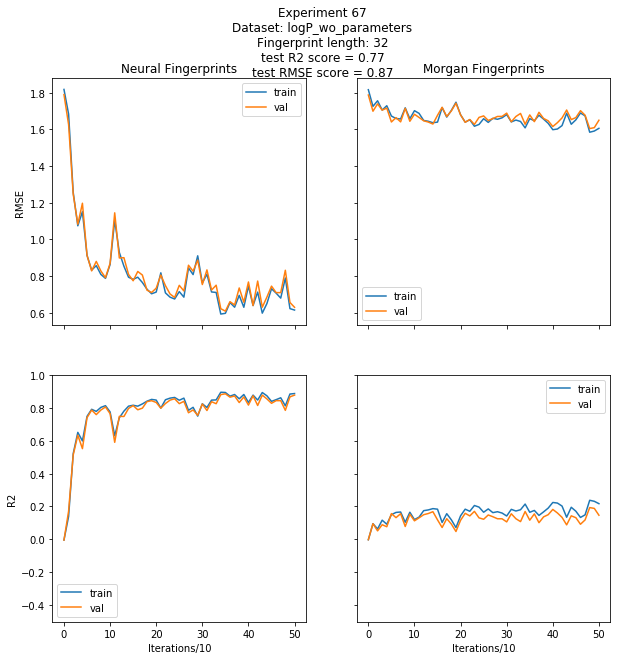

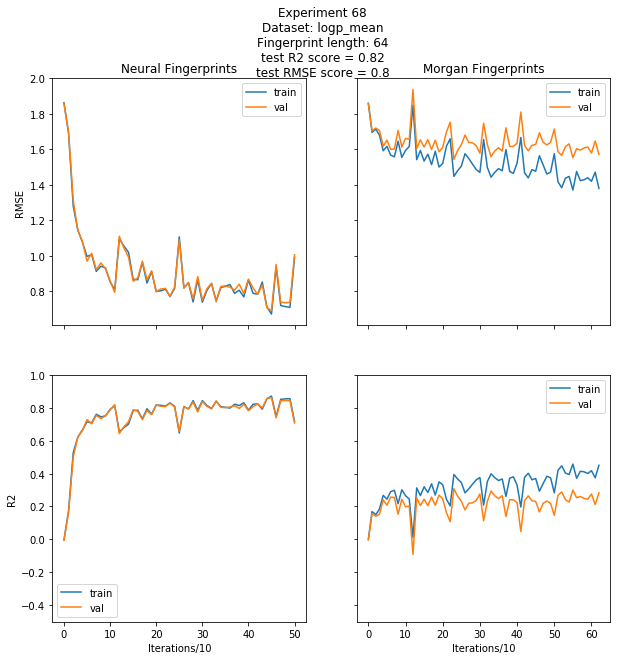

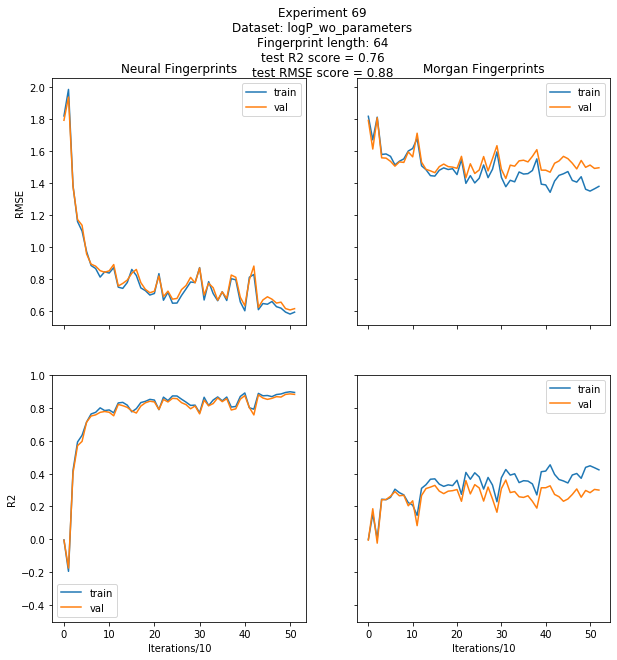

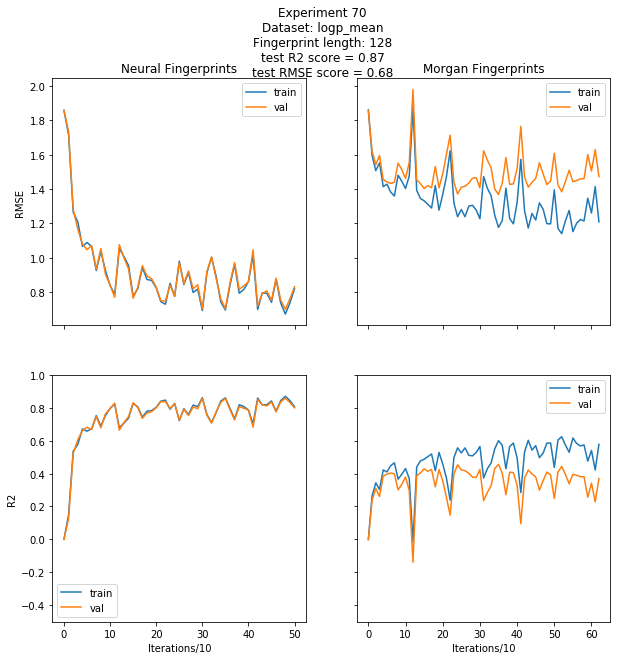

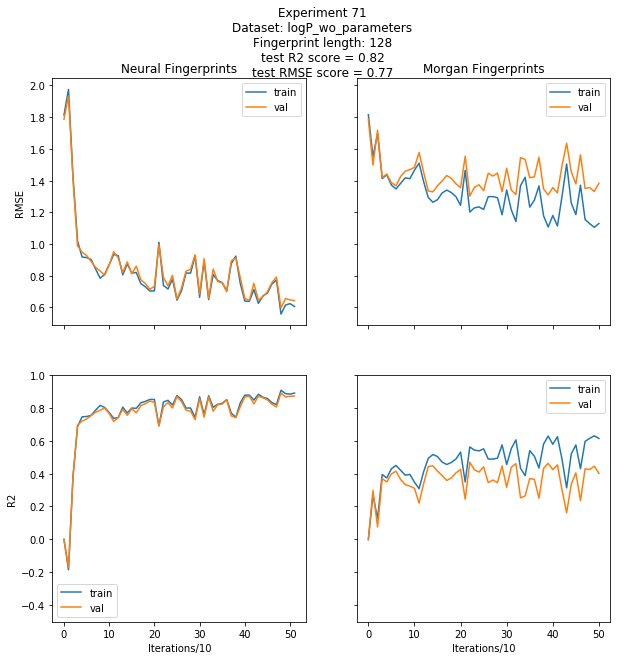

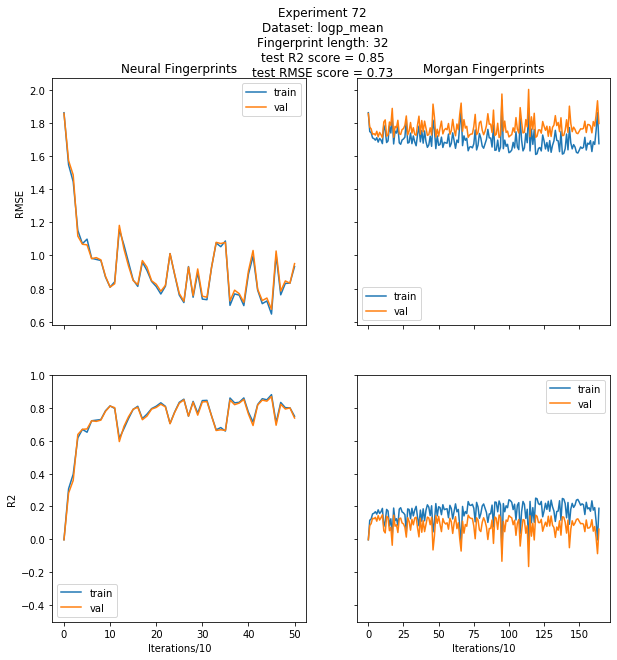

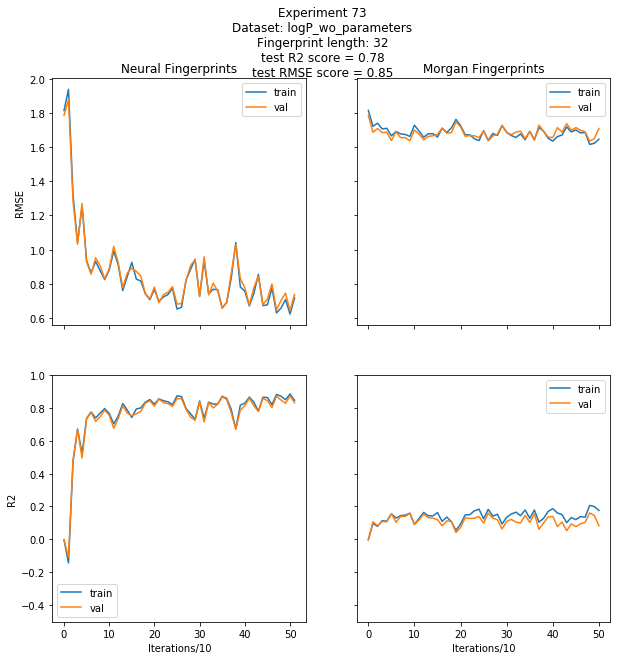

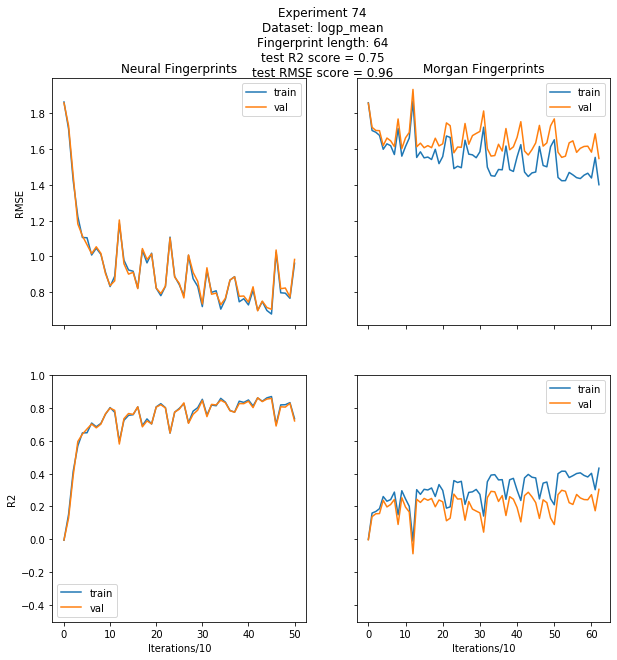

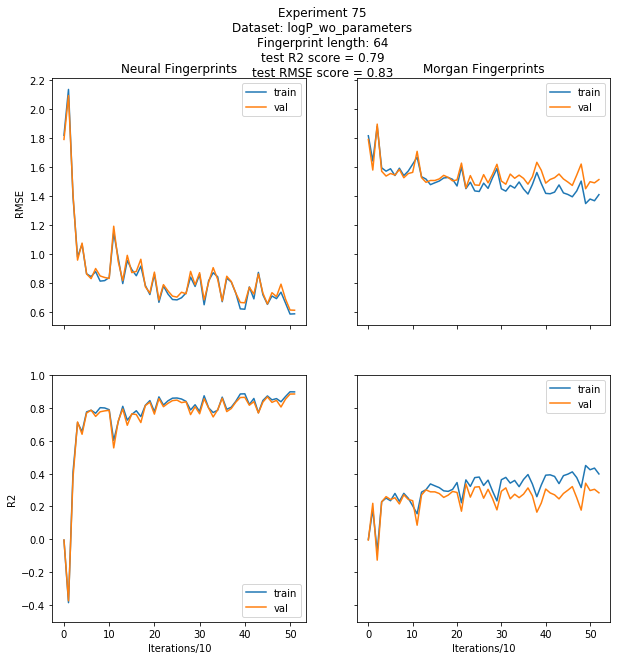

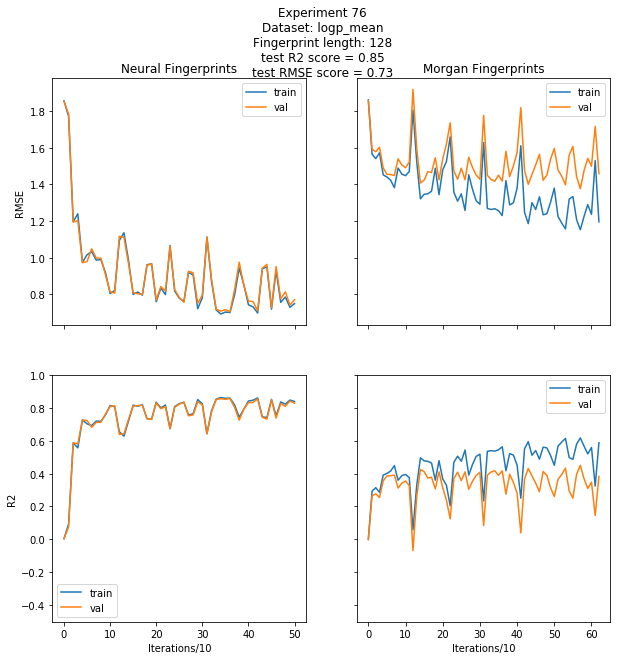

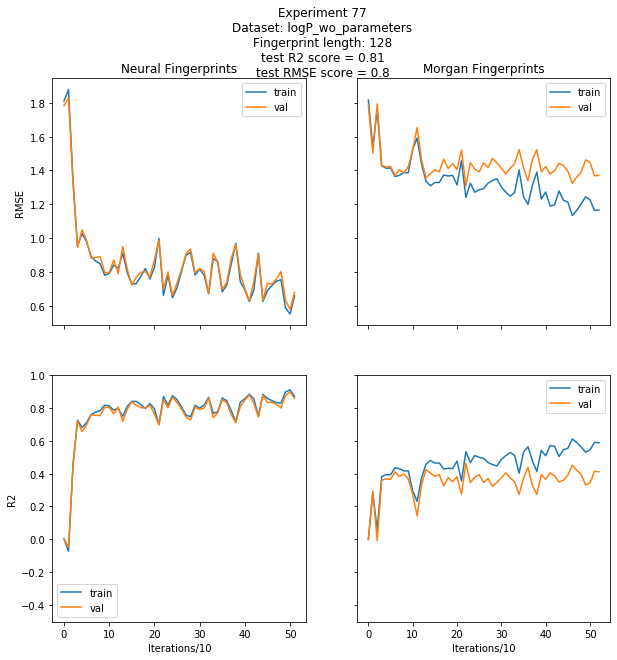

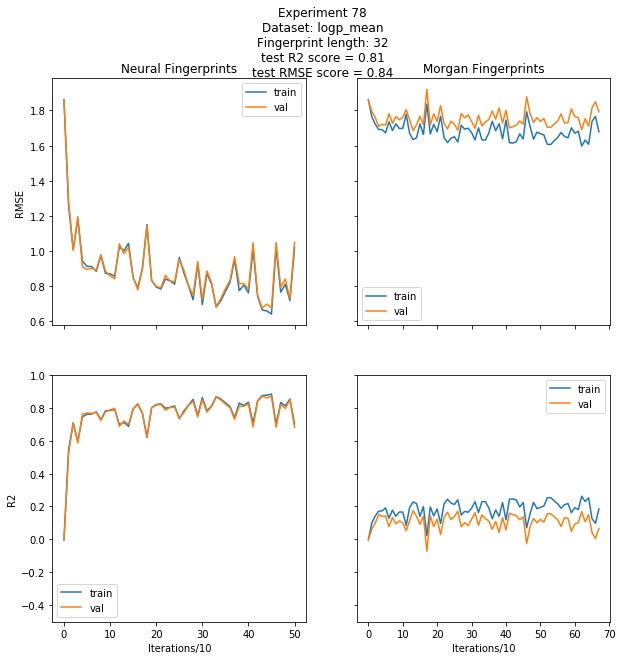

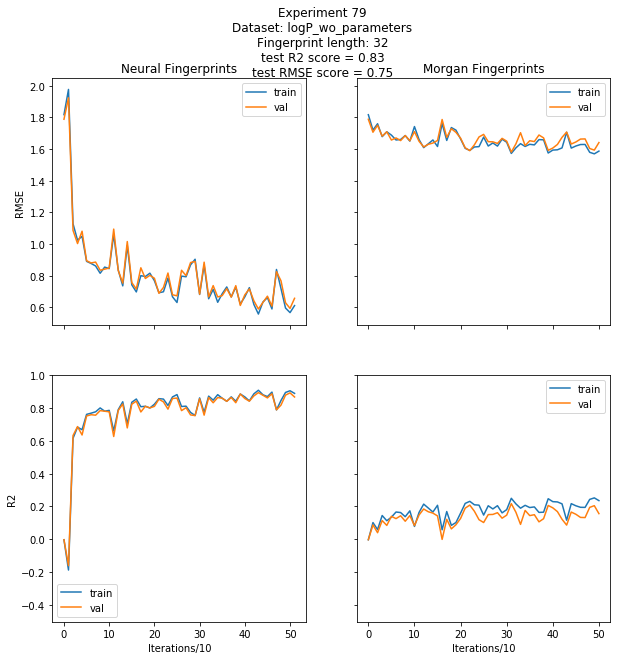

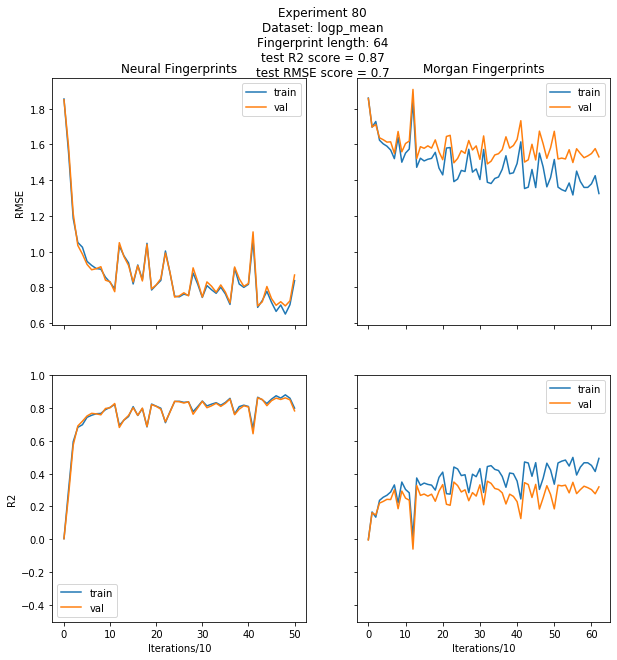

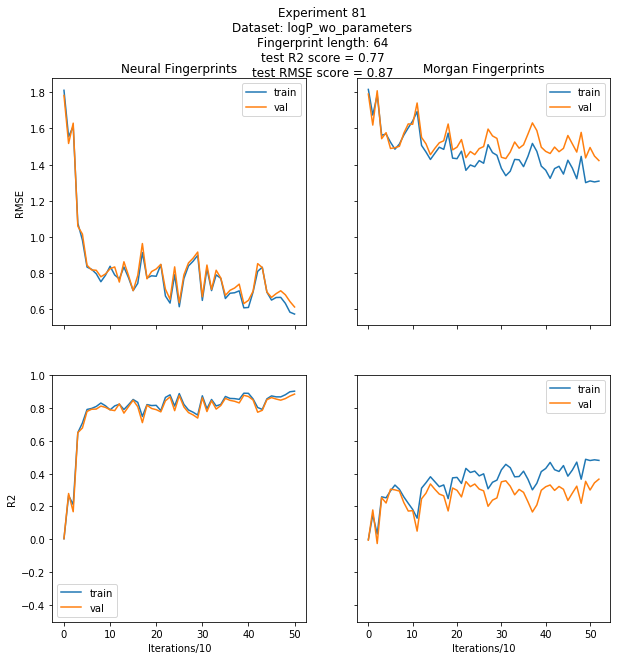

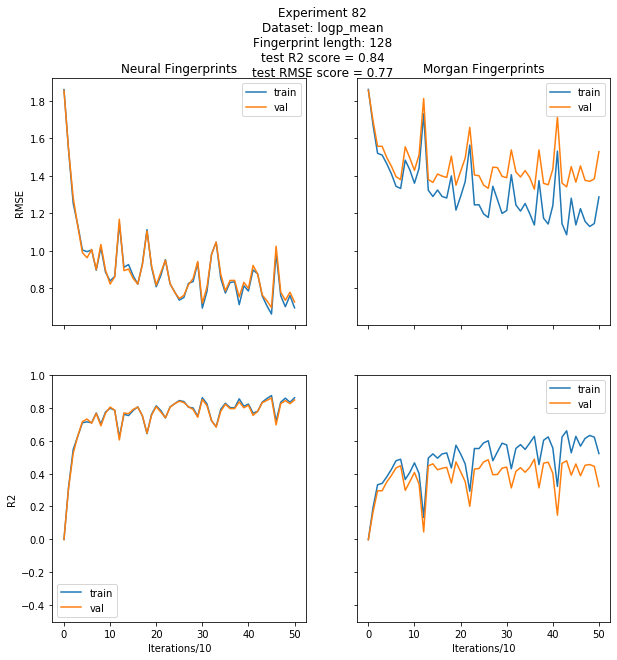

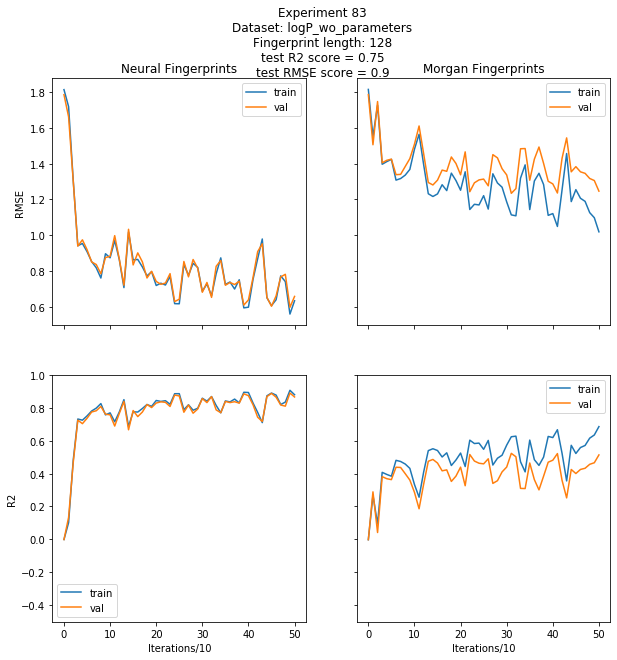

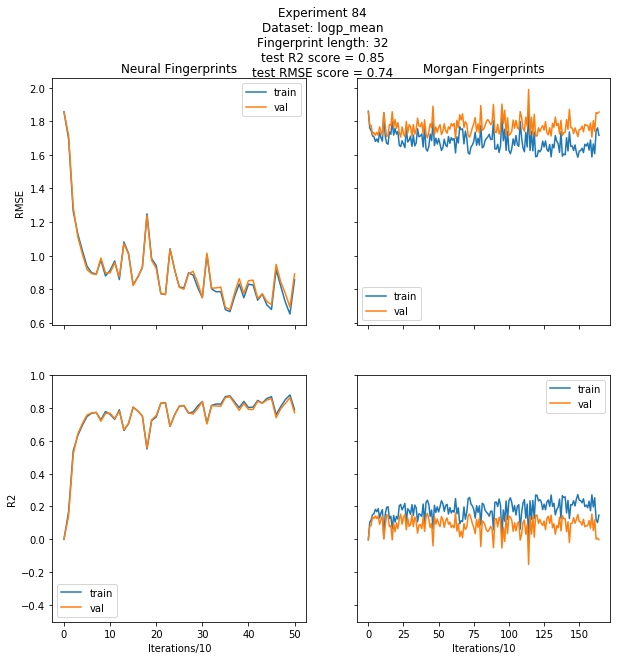

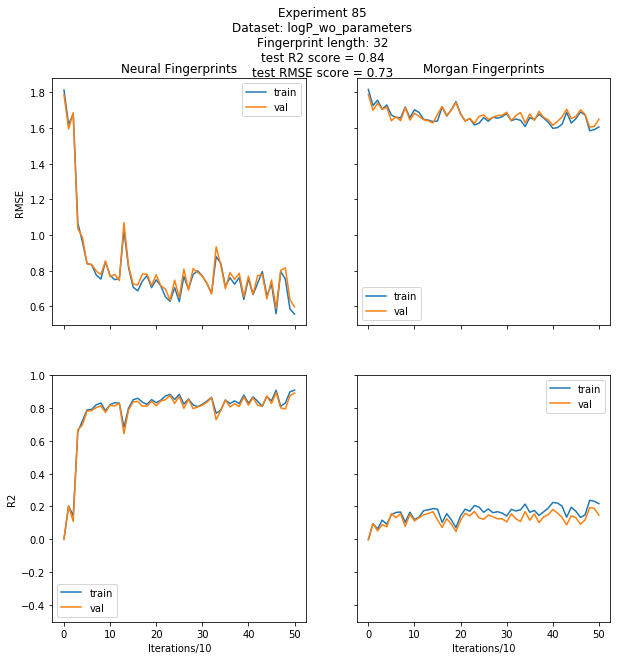

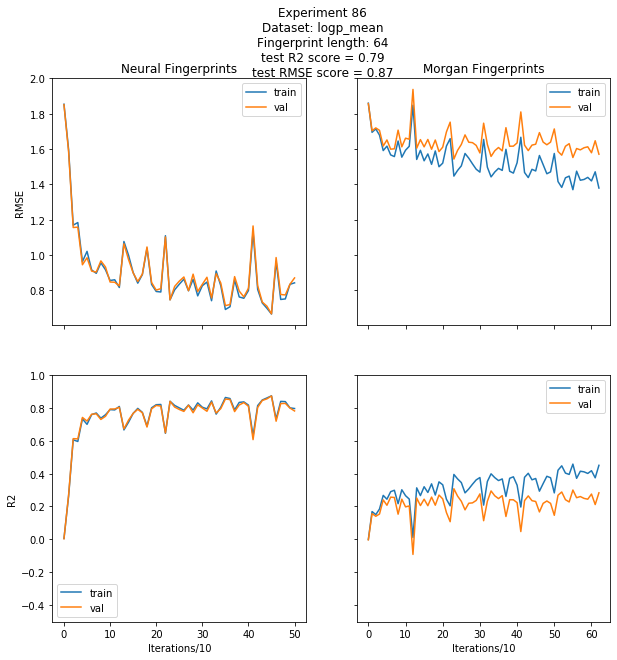

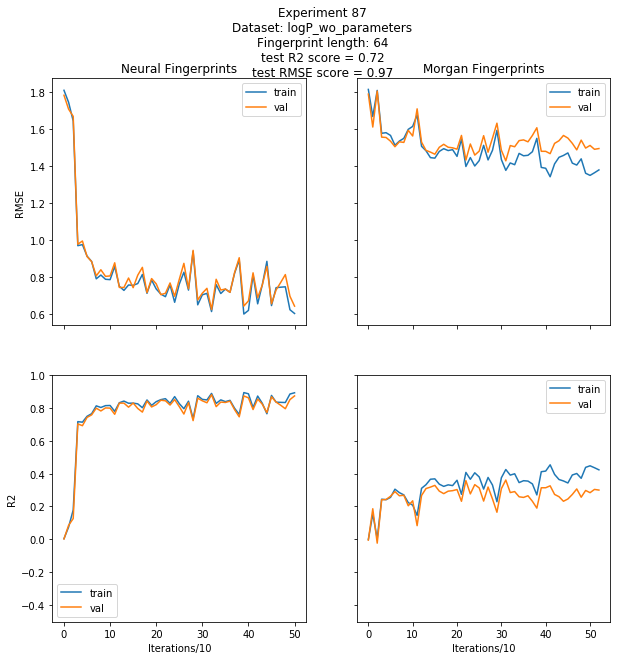

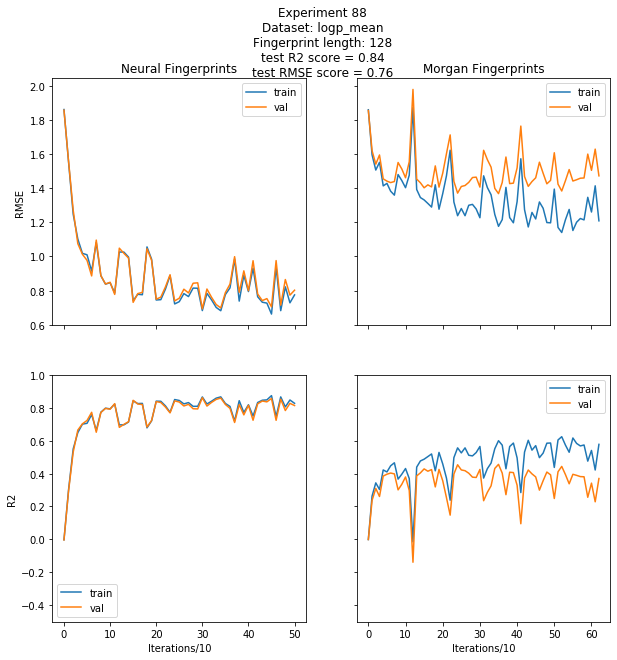

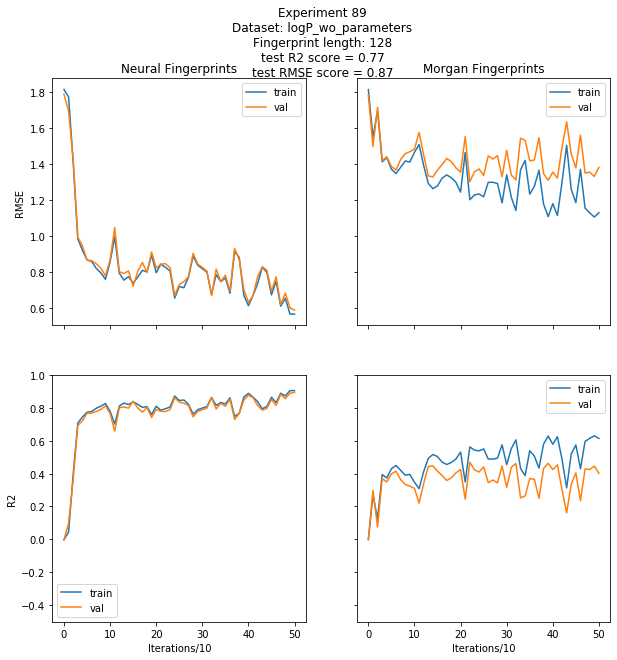

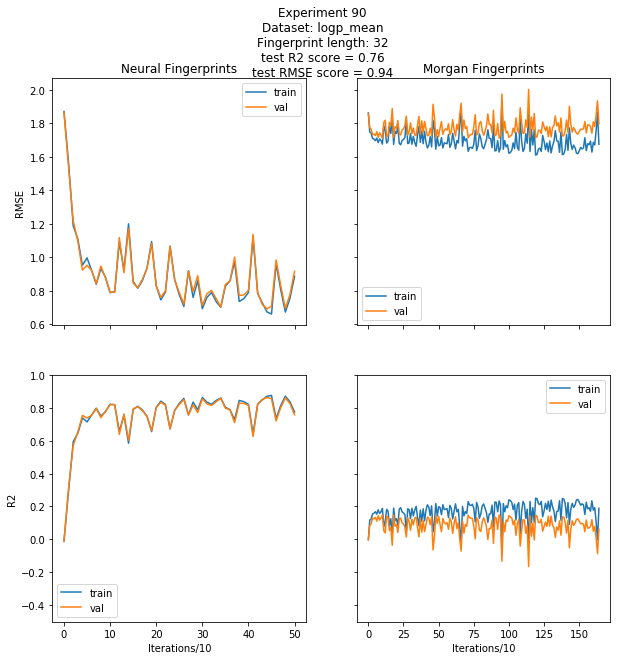

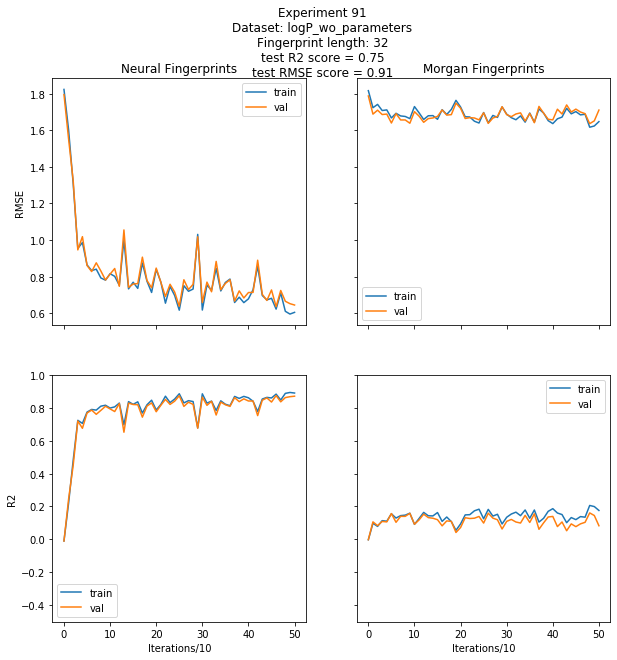

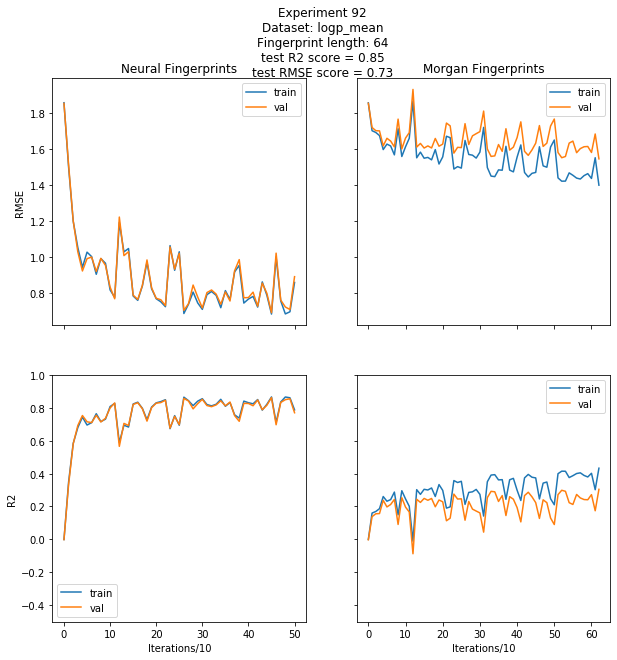

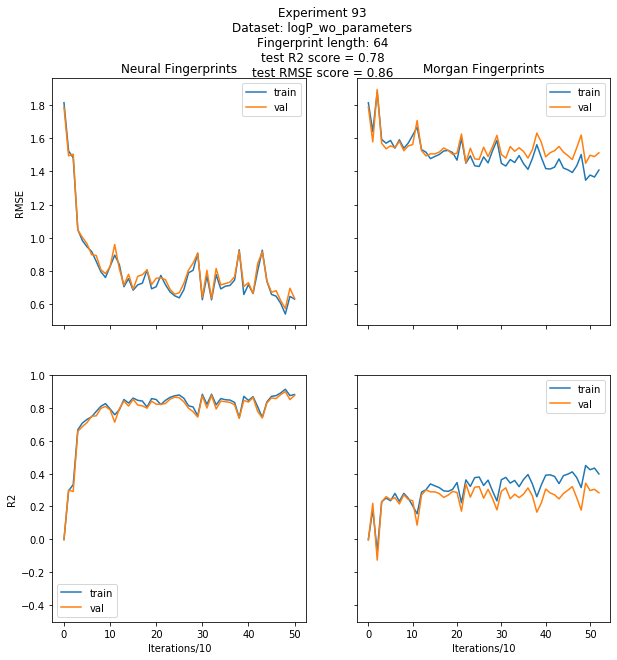

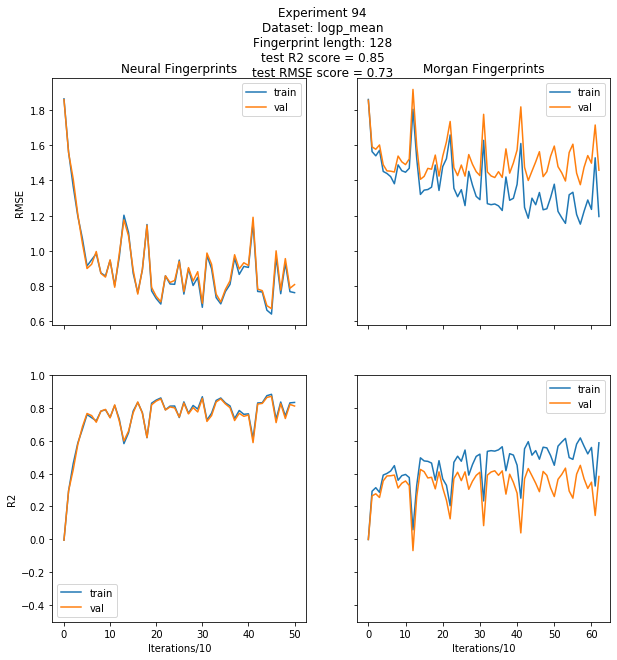

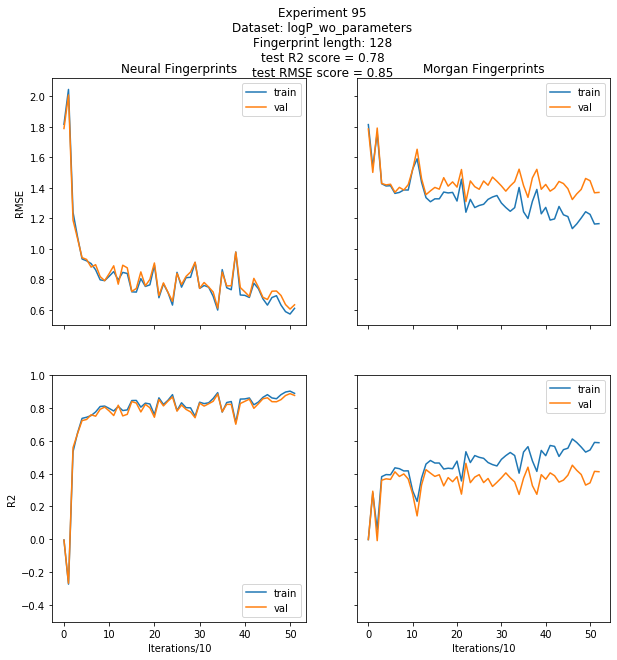

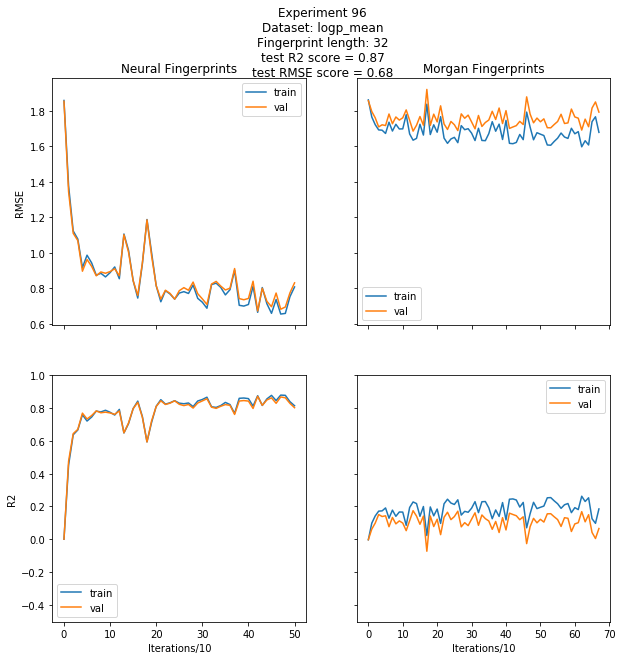

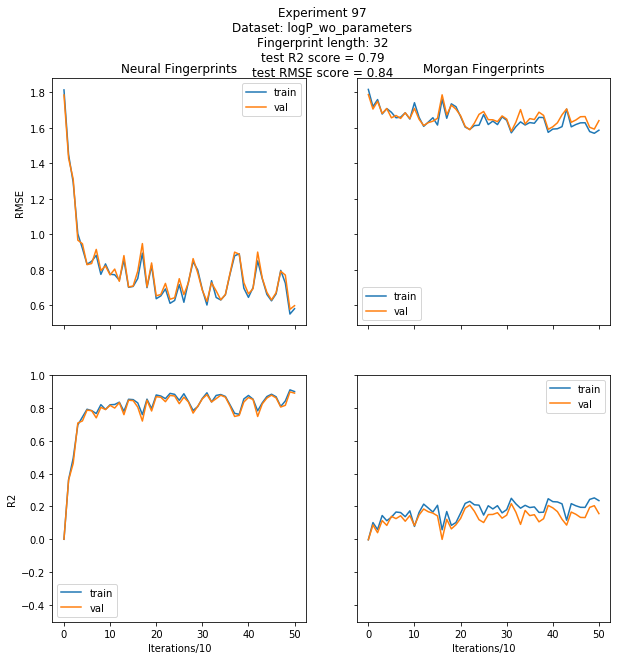

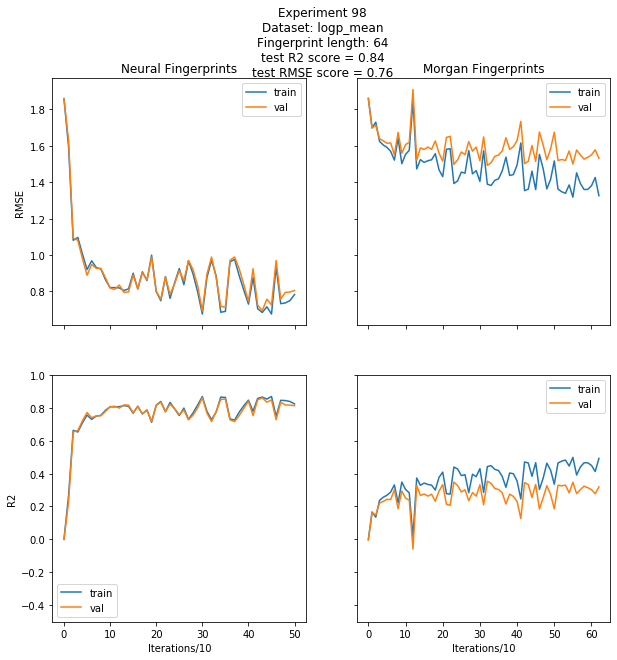

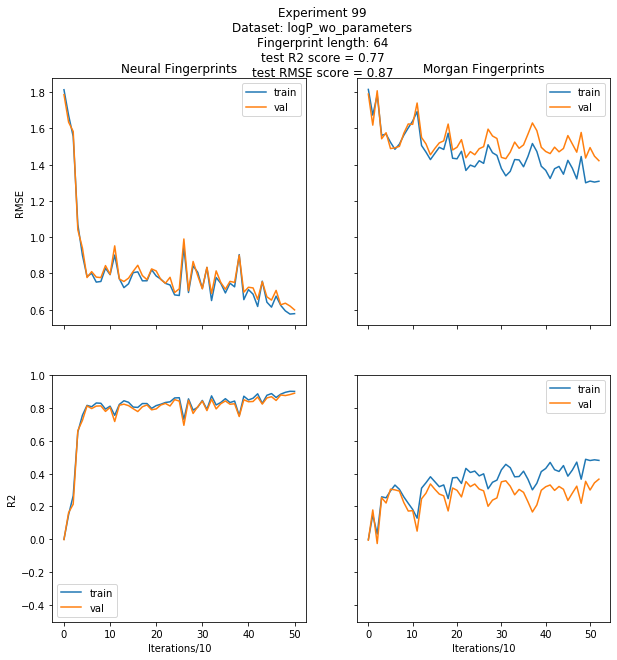

In [6]:
for NUM_EXP in NUM_EXPs:
    _ = plot_training_process(num_exp = NUM_EXP, \
                              logs_path = '../../data/raw/logs/exp_'+str(NUM_EXP), \
                              logs_filename_prefix =  str(NUM_EXP)+'_logs_metrics', \
                              logs_test_fin_file = str(NUM_EXP)+'_logs.txt', \
                              parameters_file = str(NUM_EXP)+'_parameters.json')

# Create table with summary

In [7]:
experiment_info_table = summary_table(num_exp = NUM_EXPs).sort_values(by='Neural Fingerprint test RMSE', ascending=True)
scores = list(filter(lambda x: 'Fingerprint' in x, list(experiment_info_table)))
for score in scores:
    experiment_info_table[score] = \
    experiment_info_table[score].apply(lambda x: round(x, 2))
nunique = experiment_info_table.apply(pd.Series.nunique)
cols_to_drop = nunique[nunique == 1].index
experiment_info_table_changed_parameters = experiment_info_table.drop(cols_to_drop, axis=1)
experiment_info_table_changed_parameters = experiment_info_table_changed_parameters.set_index('NUM_EXP')
experiment_info_table_changed_parameters = experiment_info_table_changed_parameters[[
 'fp_length',
 'data_file',
 'num_iters',
 'fp_depth',
 'conv_width',
 'learn_rate',                                                                                    
 'Neural Fingerprint test RMSE',                                                                                    
 'Neural Fingerprint test R2',
 'Morgan Fingerprint test R2',
 'Neural Fingerprint train RMSE',
 'Neural Fingerprint val RMSE',
 'Neural Fingerprint train R2',
 'Neural Fingerprint val R2',
 'Morgan Fingerprint train RMSE',
 'Morgan Fingerprint val RMSE',
 'Morgan Fingerprint train R2',
 'Morgan Fingerprint val R2']]

In [8]:
experiment_info_table_changed_parameters

fp_length           data_file  num_iters  fp_depth  conv_width  \
NUM_EXP                                                                   
60              32           logp_mean       2200         3          10   
102             32           logp_mean        510         4          30   
116             64           logp_mean        510         3          10   
70             128           logp_mean        510         4          10   
61              32  logP_wo_parameters       2620         3          10   
...            ...                 ...        ...       ...         ...   
19              20  logP_wo_parameters        770         4          10   
50              20           logp_mean        650         3          10   
51              20  logP_wo_parameters        870         3          10   
52              30           logp_mean        770         3          10   
53              30  logP_wo_parameters        370         3          10   

         learn_rate  Neural Fingerprint test RMSE  Neural Fingerprint test R2  \
NUM_EXP                                                                         
60             -3.0                          0.61                        0.90   
102            -3.0                          0.67                        0.88   
116            -3.0                          0.68                        0.87   
70             -3.0                          0.68                        0.87   
61             -3.0                          0.68                        0.86   
...             ...                           ...                         ...   
19             -3.0                           NaN                        0.72   
50             -2.0                           NaN                        0.53   
51             -2.0                           NaN                        0.80   
52             -2.0                           NaN                        0.81   
53             -2.0                           NaN                        0.75   

         Morgan Fingerprint test R2  Neural Fingerprint train RMSE  \
NUM_EXP                                                              
60                             0.17                           0.61   
102                            0.09                           0.77   
116                            0.34                           0.84   
70                             0.36                           0.82   
61                             0.16                           0.63   
...                             ...                            ...   
19                             0.04                           0.60   
50                            -0.12                           1.20   
51                            -0.35                           0.85   
52                            -0.03                           0.90   
53                             0.09                           1.31   

         Neural Fingerprint val RMSE  Neural Fingerprint train R2  \
NUM_EXP                                                             
60                              0.68                         0.89   
102                             0.80                         0.83   
116                             0.86                         0.79   
70                              0.83                         0.81   
61                              0.70                         0.88   
...                              ...                          ...   
19                              0.60                         0.89   
50                              1.22                         0.58   
51                              0.85                         0.78   
52                              0.92                         0.77   
53                              1.33                         0.48   

         Neural Fingerprint val R2  Morgan Fingerprint train RMSE  \
NUM_EXP                                                             
60                            0.

In [65]:
with open('../../data/raw/experiments_result','w') as f:
    f.write(experiment_info_table_changed_parameters.to_markdown())

In [50]:
experiment_info_table_sum = experiment_info_table_changed_parameters[[
 'data_file',
 'Neural Fingerprint test RMSE',  
 'Neural Fingerprint test R2',
 'Neural Fingerprint val RMSE',
 'Neural Fingerprint val R2',
 'Neural Fingerprint train RMSE',
 'Neural Fingerprint train R2',
]]

In [51]:
experiment_info_table_sum

data_file  Neural Fingerprint test RMSE  \
NUM_EXP                                                     
71                logp_mean                          0.60   
60                logp_mean                          0.61   
66                logp_mean                          0.69   
70       logP_wo_parameters                          0.67   
62                logp_mean                          0.71   
61       logP_wo_parameters                          0.68   
17       logP_wo_parameters                           NaN   
30                logp_mean                          0.76   
32       logP_wo_parameters                          0.74   
68                logp_mean                          0.80   
63       logP_wo_parameters                          0.79   
52                logp_mean                           NaN   
51       logP_wo_parameters                           NaN   
64                logp_mean                          0.90   
67       logP_wo_parameters                          0.87   
15       logP_wo_parameters                           NaN   
13       logP_wo_parameters                           NaN   
53       logP_wo_parameters                           NaN   
65       logP_wo_parameters                          0.91   
14                logp_mean                           NaN   
19       logP_wo_parameters                           NaN   
16                logp_mean                           NaN   
18                logp_mean                           NaN   
50                logp_mean                           NaN   

         Neural Fingerprint test R2  Neural Fingerprint val RMSE  \
NUM_EXP                                                            
71                             0.90                         0.71   
60                             0.90                         0.68   
66                             0.87                         0.74   
70                             0.86                         0.68   
62                             0.86                         0.63   
61                             0.86                         0.70   
17                             0.85                         0.66   
30                             0.84                         0.74   
32                             0.83                         0.65   
68                             0.82                         1.00   
63                             0.81                         0.65   
52                             0.81                         0.92   
51                             0.80                         0.85   
64                             0.78                         0.88   
67                             0.77                         0.63   
15                             0.76                         0.62   
13                             0.75                         0.76   
53                             0.75                         1.33   
65                             0.75                         0.60   
14                             0.73                         1.01   
19                             0.72                         0.60   
16                             0.70                         0.68   
18                             0.67                         0.73   
50                             0.53                         1.22   

         Neural Fingerprint val R2  Neural Fingerprint train RMSE  \
NUM_EXP                                                             
71                            0.85                           0.67   
60                            0.87                           0.61   
66                            0.84                           0.71   
70                            0.86                           0.64   
62                            0.88                           0.57   
61                            0.85                           0.63   
17                            0.86                           0.64   
30                            0.84       

In [125]:
with open('../../data/raw/experiments_result','w') as f:
    f.write(experiment_info_table_sum.to_markdown())